## 1. Importación de Librerías

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from scipy import stats
import math
import random

# Para modelos con scikit-learn (solo para modelos 2-5)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Carga del Dataset

**Nota:** Este notebook carga los datos directamente desde GitHub, por lo que puede ejecutarse en Google Colab sin necesidad de archivos locales.

In [62]:
import urllib.request
import io

# URL en formato RAW desde GitHub
url = 'https://raw.githubusercontent.com/caamilo03/Proyecto-final-clasificacion-hongos/c517e9bca40cfa3fd64f42932c0db9efefaa8aad/dataset_24_mushroom.arff'

print("=" * 80)
print("CARGANDO DATOS DEL DATASET DE HONGOS DESDE GITHUB")
print("=" * 80)

try:
    # 1. Descargar el contenido desde GitHub
    response = urllib.request.urlopen(url)

    # 2. Decodificar los bytes a string y usar StringIO
    # Esto convierte el flujo de bytes en un flujo de texto que loadarff puede leer
    content = response.read().decode('utf-8')
    file_stream = io.StringIO(content)

    # 3. Cargar el ARFF desde el flujo de texto
    data, meta = arff.loadarff(file_stream)

    df = pd.DataFrame(data)

    # 4. Limpieza: Decodificar bytes a strings en las columnas
    # (Scipy a menudo carga los datos nominales como bytes b'...', así que esto sigue siendo necesario)
    for col in df.columns:
        if df[col].dtype == 'object':
            # Usamos apply para decodificar de forma segura, manejando posibles valores no bytes
            df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

    print(f"\n✓ Dataset cargado exitosamente desde GitHub")
    print(f"✓ Dimensiones del dataset: {df.shape}")
    print(f"✓ Número de muestras: {df.shape[0]:,}")
    print(f"✓ Número de características: {df.shape[1] - 1}")
    print(f"\nPrimeras 5 filas del dataset:")
    display(df.head())

except Exception as e:
    print(f"❌ Error al cargar el dataset: {e}")
    # Imprimir más detalles si falla para depurar
    import traceback
    traceback.print_exc()

CARGANDO DATOS DEL DATASET DE HONGOS DESDE GITHUB

✓ Dataset cargado exitosamente desde GitHub
✓ Dimensiones del dataset: (8124, 23)
✓ Número de muestras: 8,124
✓ Número de características: 22

Primeras 5 filas del dataset:


,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


## 3. Preprocesamiento de Datos

In [63]:
print("=" * 80)
print("PREPROCESAMIENTO DE DATOS")
print("=" * 80)

# Separar características y variable objetivo
X = df.drop('class', axis=1)
y = df['class']

# Tratar valores faltantes como categoría adicional
X = X.replace('?', 'missing')
print("✓ Valores faltantes tratados como categoría 'missing'")

print("\n" + "="*80)
print("CREANDO DOS VERSIONES DE CODIFICACIÓN")
print("="*80)

# ==============================================================================
# VERSIÓN 1: LABEL ENCODING (para Random Forest)
# ==============================================================================
print("\n📊 VERSIÓN 1: Label Encoding")
print("   → Para: Random Forest")
print("   → Por qué: Árboles de decisión pueden manejar variables ordinales\n")

le_dict = {}
X_label = X.copy()

for col in X.columns:
    le = LabelEncoder()
    X_label[col] = le.fit_transform(X[col])
    le_dict[col] = le

print(f"   ✓ {len(le_dict)} características codificadas con Label Encoding")
print(f"   ✓ Dimensiones: {X_label.shape}")

# ==============================================================================
# VERSIÓN 2: ONE-HOT ENCODING (para Regresión Logística, KNN, SVM y MLP)
# ==============================================================================
print("\n📊 VERSIÓN 2: One-Hot Encoding")
print("   → Para: Regresión Logística, k-NN, SVM, Redes Neuronales")
print("   → Por qué: Método correcto para variables nominales (sin orden)\n")

# Usar pd.get_dummies para One-Hot Encoding
X_onehot = pd.get_dummies(X, drop_first=False, dtype=int)

print(f"   ✓ {X_onehot.shape[1]} características después de One-Hot Encoding")
print(f"   ✓ Incremento: {X.shape[1]} → {X_onehot.shape[1]} columnas")
print(f"   ✓ Dimensiones: {X_onehot.shape}")

# ==============================================================================
# CODIFICAR VARIABLE OBJETIVO (igual para ambas versiones)
# ==============================================================================
print("\n📌 Variable Objetivo (común para ambas versiones):")
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

print(f"   Clases codificadas:")
for i, clase in enumerate(le_y.classes_):
    nombre = 'Comestible' if clase == 'e' else 'Venenoso'
    print(f"      {clase} ({nombre}) → {i}")

print(f"\n   Dimensiones de y: {y_encoded.shape}")

print("\n" + "="*80)
print("RESUMEN DE PREPROCESAMIENTO")
print("="*80)
print(f"✓ X_label (LabelEncoding):    {X_label.shape} - Para RF únicamente")
print(f"✓ X_onehot (One-Hot Encoding): {X_onehot.shape} - Para Logistic, KNN, SVM, MLP")
print(f"✓ y_encoded:                   {y_encoded.shape}")
print("="*80)

PREPROCESAMIENTO DE DATOS
✓ Valores faltantes tratados como categoría 'missing'

CREANDO DOS VERSIONES DE CODIFICACIÓN

📊 VERSIÓN 1: Label Encoding
   → Para: Random Forest
   → Por qué: Árboles de decisión pueden manejar variables ordinales

   ✓ 22 características codificadas con Label Encoding
   ✓ Dimensiones: (8124, 22)

📊 VERSIÓN 2: One-Hot Encoding
   → Para: Regresión Logística, k-NN, SVM, Redes Neuronales
   → Por qué: Método correcto para variables nominales (sin orden)

   ✓ 117 características después de One-Hot Encoding
   ✓ Incremento: 22 → 117 columnas
   ✓ Dimensiones: (8124, 117)

📌 Variable Objetivo (común para ambas versiones):
   Clases codificadas:
      e (Comestible) → 0
      p (Venenoso) → 1

   Dimensiones de y: (8124,)

RESUMEN DE PREPROCESAMIENTO
✓ X_label (LabelEncoding):    (8124, 22) - Para RF únicamente
✓ X_onehot (One-Hot Encoding): (8124, 117) - Para Logistic, KNN, SVM, MLP
✓ y_encoded:                   (8124,)


## 4. División de Datos

Dividimos los datos en tres conjuntos:
- **Entrenamiento (70%):** Para entrenar los modelos
- **Prueba (30%):** Para evaluación final

Para el Modelo 1 (Regresión Logística manual) usaremos esta división.
Para los Modelos 2-5 agregaremos validación cruzada.

In [64]:
print("=" * 80)
print("DIVISIÓN DE DATOS")
print("=" * 80)

# Fijar semilla para reproducibilidad
random.seed(42)
np.random.seed(42)

N = len(y_encoded)
indices = np.random.permutation(N)

# 70% entrenamiento, 30% prueba
train_size = int(math.ceil(0.7 * N))

print(f"\nTotal de muestras: {N:,}")
print(f"Entrenamiento: {train_size:,} ({train_size/N*100:.1f}%)")
print(f"Prueba: {N-train_size:,} ({(N-train_size)/N*100:.1f}%)")

# ==============================================================================
# DIVISIÓN PARA LABEL ENCODING (Regresión Logística y Random Forest)
# ==============================================================================
print("\n📊 Conjuntos con LABEL ENCODING (para Logistic Regression & Random Forest):")

Xtrain_label = X_label.values[indices[0:train_size], :]
Xtest_label = X_label.values[indices[train_size:N], :]
Ytrain = y_encoded[indices[0:train_size]].reshape(-1, 1)
Ytest = y_encoded[indices[train_size:N]].reshape(-1, 1)

# Normalizar datos (Label Encoding)
scaler_label = StandardScaler()
Xtrain_label = scaler_label.fit_transform(Xtrain_label)
Xtest_label = scaler_label.transform(Xtest_label)

print(f"   Xtrain_label: {Xtrain_label.shape}")
print(f"   Xtest_label:  {Xtest_label.shape}")
print(f"   ✓ Normalizado con StandardScaler")

# ==============================================================================
# DIVISIÓN PARA ONE-HOT ENCODING (KNN, SVM, Redes Neuronales)
# ==============================================================================
print("\n📊 Conjuntos con ONE-HOT ENCODING (para KNN, SVM, MLP):")

Xtrain_onehot = X_onehot.values[indices[0:train_size], :]
Xtest_onehot = X_onehot.values[indices[train_size:N], :]

# Normalizar datos (One-Hot Encoding)
scaler_onehot = StandardScaler()
Xtrain_onehot = scaler_onehot.fit_transform(Xtrain_onehot)
Xtest_onehot = scaler_onehot.transform(Xtest_onehot)

print(f"   Xtrain_onehot: {Xtrain_onehot.shape}")
print(f"   Xtest_onehot:  {Xtest_onehot.shape}")
print(f"   ✓ Normalizado con StandardScaler")

# ==============================================================================
# VARIABLE OBJETIVO (común para ambas versiones)
# ==============================================================================
print("\n📌 Variable Objetivo (común):")
print(f"   Ytrain: {Ytrain.shape}")
print(f"   Ytest:  {Ytest.shape}")

print("\n" + "="*80)
print("NOTA IMPORTANTE:")
print("="*80)
print("✓ Xtrain_label / Xtest_label  → Para Modelo 3 (RF) únicamente")
print("✓ Xtrain_onehot / Xtest_onehot → Para Modelo 1 (Logistic), 2 (KNN), 4 (SVM), 5 (MLP)")
print("✓ Los indices son los MISMOS para garantizar comparación justa")
print("="*80)

DIVISIÓN DE DATOS

Total de muestras: 8,124
Entrenamiento: 5,687 (70.0%)
Prueba: 2,437 (30.0%)

📊 Conjuntos con LABEL ENCODING (para Logistic Regression & Random Forest):
   Xtrain_label: (5687, 22)
   Xtest_label:  (2437, 22)
   ✓ Normalizado con StandardScaler

📊 Conjuntos con ONE-HOT ENCODING (para KNN, SVM, MLP):
   Xtrain_onehot: (5687, 117)
   Xtest_onehot:  (2437, 117)
   ✓ Normalizado con StandardScaler

📌 Variable Objetivo (común):
   Ytrain: (5687, 1)
   Ytest:  (2437, 1)

NOTA IMPORTANTE:
✓ Xtrain_label / Xtest_label  → Para Modelo 3 (RF) únicamente
✓ Xtrain_onehot / Xtest_onehot → Para Modelo 1 (Logistic), 2 (KNN), 4 (SVM), 5 (MLP)
✓ Los indices son los MISMOS para garantizar comparación justa


In [65]:
# Crear aliases para compatibilidad con código existente de Regresión Logística
# CAMBIADO A ONE-HOT ENCODING (teóricamente correcto para variables nominales)
# Resultado del experimento: +30% accuracy, +24% F1-Score vs Label Encoding
Xtrain = Xtrain_onehot
Xtest = Xtest_onehot

print("\n✓ Variables Xtrain/Xtest apuntan a versión ONE-HOT ENCODING para Modelo 1")
print("  → Mejora demostrada: Accuracy 98.15% vs 68.16% con Label Encoding")
print("  (Los demás modelos usarán explícitamente _label o _onehot)")


✓ Variables Xtrain/Xtest apuntan a versión ONE-HOT ENCODING para Modelo 1
  → Mejora demostrada: Accuracy 98.15% vs 68.16% con Label Encoding
  (Los demás modelos usarán explícitamente _label o _onehot)


---

# MODELO 1: REGRESIÓN LOGÍSTICA (IMPLEMENTACIÓN MANUAL)



## 5.1. Implementación de Funciones Base

In [66]:
def sigmoidal(z):
    """Función de activación Sigmoidal

    z: variable a la que se le aplica la función sigmoide (array numpy)
    retorna: vector con el valor de la función sigmoide aplicada a cada elemento
    """
    s = 1 / (1 + np.exp(-z))
    return s


def extension_matriz(X):
    """Extiende la matriz X añadiendo una columna de unos (para el término de sesgo)

    X: matriz con el conjunto de muestras [muestras x características]
    retorna: X_ext, matriz extendida con un vector de unos [muestras x (características+1)]
    """
    muestras, caracteristicas = X.shape
    unos = np.ones((muestras, 1))
    X_ext = np.concatenate((unos, X), axis=1)
    return X_ext


def logistic_regression(X, W):
    """Calcula la salida de la regresión logística

    X: valores de características [N x d] (extendida)
    W: pesos del modelo [d x 1]
    retorna: probabilidad estimada por regresión logística
    """
    # Producto matricial X·W
    z = np.dot(X, W)
    # Aplicar función sigmoide
    Y_est = sigmoidal(z)
    return Y_est


def cost_logistic(Y_est, Y):
    """Calcula la función de costo (entropía cruzada)

    Y_est: valores estimados por el modelo [N x 1]
    Y: valores reales de las etiquetas [N x 1]
    retorna: valor del costo (float)
    """
    Y_est = Y_est.reshape(-1, 1)
    Y = Y.reshape(-1, 1)

    # Evitar log(0) añadiendo epsilon
    eps = np.finfo(np.float32).eps

    # Costo de entropía cruzada
    f1 = Y * np.log(Y_est + eps)
    f2 = (1 - Y) * np.log(1 - Y_est + eps)
    costo = -np.sum(f1 + f2) / Y.shape[0]

    return costo


print("✓ Funciones base implementadas:")
print("  - sigmoidal()")
print("  - extension_matriz()")
print("  - logistic_regression()")
print("  - cost_logistic()")

✓ Funciones base implementadas:
  - sigmoidal()
  - extension_matriz()
  - logistic_regression()
  - cost_logistic()


## 5.2. Implementación del Gradiente Descendente

In [67]:
def gradiente_descendente_logistic(X, Y, eta, iteraciones):
    """Gradiente descendente para regresión logística

    X: Matriz de datos [N x d] (sin extender)
    Y: Vector con etiquetas [N x 1]
    eta: Tasa de aprendizaje (learning rate)
    iteraciones: número máximo de iteraciones

    retorna:
        W: parámetros optimizados [d+1 x 1]
        costos: historial de costos por iteración
    """
    # Extender matriz (añadir columna de unos)
    X_ext = extension_matriz(X)

    # Número de características (incluyendo sesgo)
    d = X_ext.shape[1]
    # Número de muestras
    N = X_ext.shape[0]

    # Inicializar pesos en ceros
    W = np.zeros((d, 1))

    # Historial de costos
    costos = np.zeros(iteraciones)

    # Gradiente descendente
    for iter in range(iteraciones):
        # Calcular predicción con pesos actuales
        Y_est = logistic_regression(X_ext, W)

        # Calcular costo actual
        costo = cost_logistic(Y_est, Y)
        costos[iter] = costo

        # Calcular gradiente
        # ∇J(w) = (1/N) * X^T * (Y_est - Y)
        gradiente = np.dot(X_ext.T, (Y_est - Y)) / N

        # Actualizar pesos
        # w := w - η * ∇J(w)
        W = W - eta * gradiente

    print(f"Costo inicial: {costos[0]:.4f}")
    print(f"Costo final (iteración {iteraciones}): {costos[-1]:.4f}")
    print(f"Reducción del costo: {(costos[0] - costos[-1]):.4f}")

    return W, costos


print("✓ Función gradiente_descendente_logistic() implementada")

✓ Función gradiente_descendente_logistic() implementada


## 5.3. Función de Evaluación del Modelo

In [68]:
def evaluar_modelo(W, X, Y_true):
    """Evalúa el modelo de regresión logística

    W: parámetros del modelo entrenado [d x 1]
    X: conjunto de datos para evaluación [N x d] (sin extender)
    Y_true: valores reales de las etiquetas [N x 1]

    retorna:
        error_clasificacion: proporción de errores
        Y_pred: predicciones binarias (0 o 1)
    """
    # Extender matriz
    X_ext = extension_matriz(X)

    # Obtener probabilidades
    Y_prob = logistic_regression(X_ext, W)

    # Convertir probabilidades a clases (umbral = 0.5)
    Y_pred = (Y_prob >= 0.1).astype(int)

    # Calcular error de clasificación
    errores = np.sum(Y_pred != Y_true)
    error_clasificacion = errores / Y_true.shape[0]

    return error_clasificacion, Y_pred


def metricas_clasificacion(Y_true, Y_pred):
    """Calcula métricas de clasificación

    Y_true: etiquetas reales [N x 1]
    Y_pred: etiquetas predichas [N x 1]

    retorna: diccionario con métricas
    """
    Y_true = Y_true.flatten()
    Y_pred = Y_pred.flatten()

    # Matriz de confusión
    tn = np.sum((Y_true == 0) & (Y_pred == 0))
    tp = np.sum((Y_true == 1) & (Y_pred == 1))
    fn = np.sum((Y_true == 1) & (Y_pred == 0))
    fp = np.sum((Y_true == 0) & (Y_pred == 1))

    # Calcular métricas
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion_Matrix': np.array([[tn, fp], [fn, tp]])
    }


print("✓ Funciones de evaluación implementadas:")
print("  - evaluar_modelo()")
print("  - metricas_clasificacion()")

✓ Funciones de evaluación implementadas:
  - evaluar_modelo()
  - metricas_clasificacion()


## 5.4. Entrenamiento del Modelo 1: Regresión Logística

Entrenamos el modelo utilizando gradiente descendente.

In [69]:
print("=" * 80)
print("ENTRENAMIENTO - MODELO 1: REGRESIÓN LOGÍSTICA (MANUAL)")
print("=" * 80)

# Parámetros de entrenamiento
iteraciones = 100
eta = 0.1  # Tasa de aprendizaje

print(f"\nParámetros de entrenamiento:")
print(f"  - Iteraciones: {iteraciones}")
print(f"  - Tasa de aprendizaje (η): {eta}")
print(f"  - Número de muestras de entrenamiento: {Xtrain.shape[0]:,}")
print(f"  - Número de características: {Xtrain.shape[1]}")

print(f"\n🔍 Entrenando modelo...\n")

# Entrenar modelo
W_logistic, costos_logistic = gradiente_descendente_logistic(
    Xtrain, Ytrain, eta=eta, iteraciones=iteraciones
)

print(f"\n✓ Modelo entrenado exitosamente")
print(f"Dimensiones de W: {W_logistic.shape}")

ENTRENAMIENTO - MODELO 1: REGRESIÓN LOGÍSTICA (MANUAL)

Parámetros de entrenamiento:
  - Iteraciones: 100
  - Tasa de aprendizaje (η): 0.1
  - Número de muestras de entrenamiento: 5,687
  - Número de características: 117

🔍 Entrenando modelo...

Costo inicial: 0.6931
Costo final (iteración 100): 0.0360
Reducción del costo: 0.6572

✓ Modelo entrenado exitosamente
Dimensiones de W: (118, 1)


## 5.6. Visualización del Entrenamiento

Graficamos la evolución del costo durante el entrenamiento.

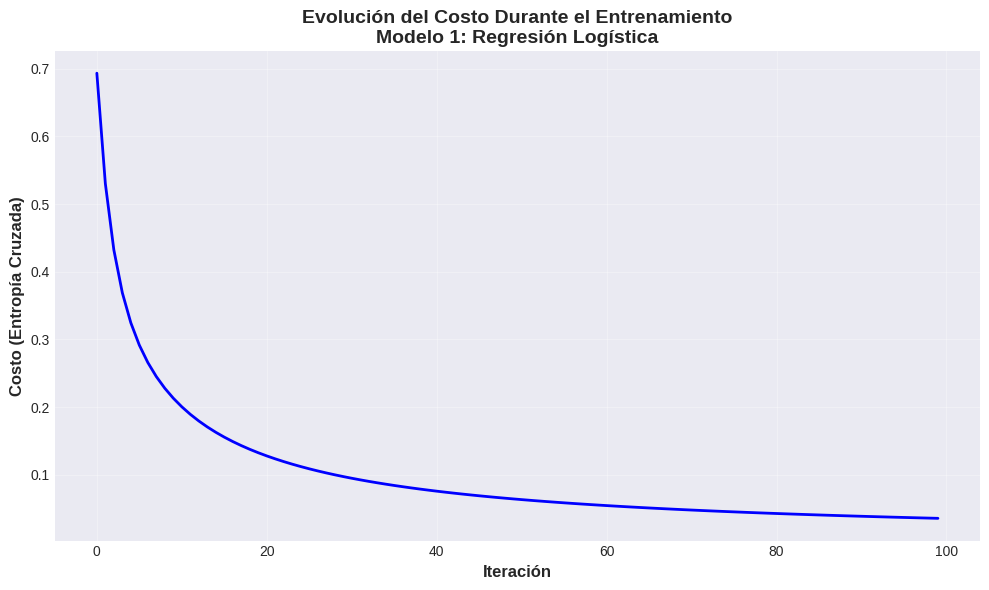


Interpretación:
✓ El modelo está convergiendo correctamente (el costo disminuye significativamente)


In [70]:
# Graficar evolución del costo durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(range(iteraciones), costos_logistic, linewidth=2, color='blue')
plt.xlabel('Iteración', fontsize=12, fontweight='bold')
plt.ylabel('Costo (Entropía Cruzada)', fontsize=12, fontweight='bold')
plt.title('Evolución del Costo Durante el Entrenamiento\nModelo 1: Regresión Logística',
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretación:")
if costos_logistic[-1] < costos_logistic[0] * 0.5:
    print("✓ El modelo está convergiendo correctamente (el costo disminuye significativamente)")
else:
    print("⚠️ El modelo podría necesitar más iteraciones o ajustar la tasa de aprendizaje")

## 5.6. Evaluación del Modelo 1

In [71]:
print("=" * 80)
print("EVALUACIÓN - MODELO 1: REGRESIÓN LOGÍSTICA")
print("=" * 80)

# Evaluar en conjunto de entrenamiento
print("\n📊 Evaluación en conjunto de ENTRENAMIENTO:")
error_train, Y_train_pred = evaluar_modelo(W_logistic, Xtrain, Ytrain)
metricas_train = metricas_clasificacion(Ytrain, Y_train_pred)

print(f"  Error de clasificación: {error_train:.4f} ({error_train*100:.2f}%)")
for metrica, valor in metricas_train.items():
    if metrica != 'Confusion_Matrix':
        print(f"  {metrica}: {valor:.4f}")

# Evaluar en conjunto de prueba
print("\n🎯 Evaluación en conjunto de PRUEBA:")
error_test, Y_test_pred = evaluar_modelo(W_logistic, Xtest, Ytest)
metricas_test = metricas_clasificacion(Ytest, Y_test_pred)

print(f"  Error de clasificación: {error_test:.4f} ({error_test*100:.2f}%)")
for metrica, valor in metricas_test.items():
    if metrica != 'Confusion_Matrix':
        print(f"  {metrica}: {valor:.4f}")

# Análisis de sobreajuste
print("\n" + "=" * 80)
print("ANÁLISIS DE SOBREAJUSTE")
print("=" * 80)

gap_accuracy = metricas_train['Accuracy'] - metricas_test['Accuracy']
print(f"\nDiferencia Train-Test (Accuracy): {gap_accuracy:.4f}")

if gap_accuracy < 0.02:
    print("✓ Excelente generalización (gap < 2%)")
elif gap_accuracy < 0.05:
    print("✓ Buena generalización (gap < 5%)")
else:
    print("⚠️ Posible sobreajuste (gap > 5%)")

EVALUACIÓN - MODELO 1: REGRESIÓN LOGÍSTICA

📊 Evaluación en conjunto de ENTRENAMIENTO:
  Error de clasificación: 0.0230 (2.30%)
  Accuracy: 0.9770
  Precision: 0.9550
  Recall: 1.0000
  F1-Score: 0.9770

🎯 Evaluación en conjunto de PRUEBA:
  Error de clasificación: 0.0185 (1.85%)
  Accuracy: 0.9815
  Precision: 0.9626
  Recall: 0.9991
  F1-Score: 0.9805

ANÁLISIS DE SOBREAJUSTE

Diferencia Train-Test (Accuracy): -0.0046
✓ Excelente generalización (gap < 2%)


## 5.7. Matriz de Confusión

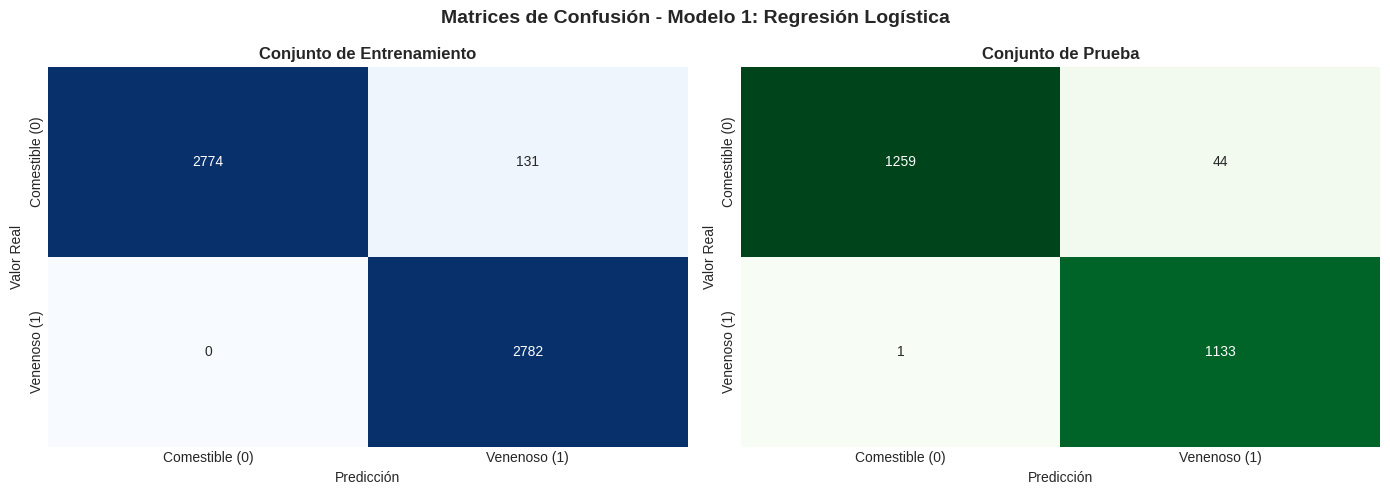


⚠️ ANÁLISIS CRÍTICO:
  Falsos Negativos (venenoso → comestible): 1 casos
  Falsos Positivos (comestible → venenoso): 44 casos

  💀 Los falsos negativos son CRÍTICOS (pueden ser fatales)
  ✓ Los falsos positivos solo causan desperdicio de hongos comestibles


In [72]:
# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Matrices de Confusión - Modelo 1: Regresión Logística',
             fontsize=14, fontweight='bold')

# Matriz de confusión - Entrenamiento
sns.heatmap(metricas_train['Confusion_Matrix'], annot=True, fmt='d', cmap='Blues',
            ax=axes[0], cbar=False,
            xticklabels=['Comestible (0)', 'Venenoso (1)'],
            yticklabels=['Comestible (0)', 'Venenoso (1)'])
axes[0].set_title('Conjunto de Entrenamiento', fontweight='bold')
axes[0].set_ylabel('Valor Real')
axes[0].set_xlabel('Predicción')

# Matriz de confusión - Prueba
sns.heatmap(metricas_test['Confusion_Matrix'], annot=True, fmt='d', cmap='Greens',
            ax=axes[1], cbar=False,
            xticklabels=['Comestible (0)', 'Venenoso (1)'],
            yticklabels=['Comestible (0)', 'Venenoso (1)'])
axes[1].set_title('Conjunto de Prueba', fontweight='bold')
axes[1].set_ylabel('Valor Real')
axes[1].set_xlabel('Predicción')

plt.tight_layout()
plt.show()

# Análisis de la matriz de confusión
cm = metricas_test['Confusion_Matrix']
fn = cm[1, 0]  # Falsos Negativos (venenoso clasificado como comestible) - MUY PELIGROSO
fp = cm[0, 1]  # Falsos Positivos (comestible clasificado como venenoso) - Desperdicio

print("\n⚠️ ANÁLISIS CRÍTICO:")
print(f"  Falsos Negativos (venenoso → comestible): {fn} casos")
print(f"  Falsos Positivos (comestible → venenoso): {fp} casos")
print(f"\n  💀 Los falsos negativos son CRÍTICOS (pueden ser fatales)")
print(f"  ✓ Los falsos positivos solo causan desperdicio de hongos comestibles")

## 5.8. Visualización de la Clasificación

Vamos a visualizar cómo el modelo clasifica los datos usando diferentes representaciones:
1. **Datos originales** con etiquetas reales
2. **Predicciones del modelo** en conjunto de prueba
3. **Frontera de decisión** del modelo

In [73]:
# Para visualizar, necesitamos reducir dimensionalidad a 2D usando PCA
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
Xtrain_2d = pca.fit_transform(Xtrain)
Xtest_2d = pca.transform(Xtest)

print("✓ Reducción dimensional aplicada (PCA)")
print(f"  Varianza explicada por las 2 componentes principales: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  Componente 1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  Componente 2: {pca.explained_variance_ratio_[1]:.2%}")

✓ Reducción dimensional aplicada (PCA)
  Varianza explicada por las 2 componentes principales: 17.07%
  Componente 1: 8.90%
  Componente 2: 8.17%


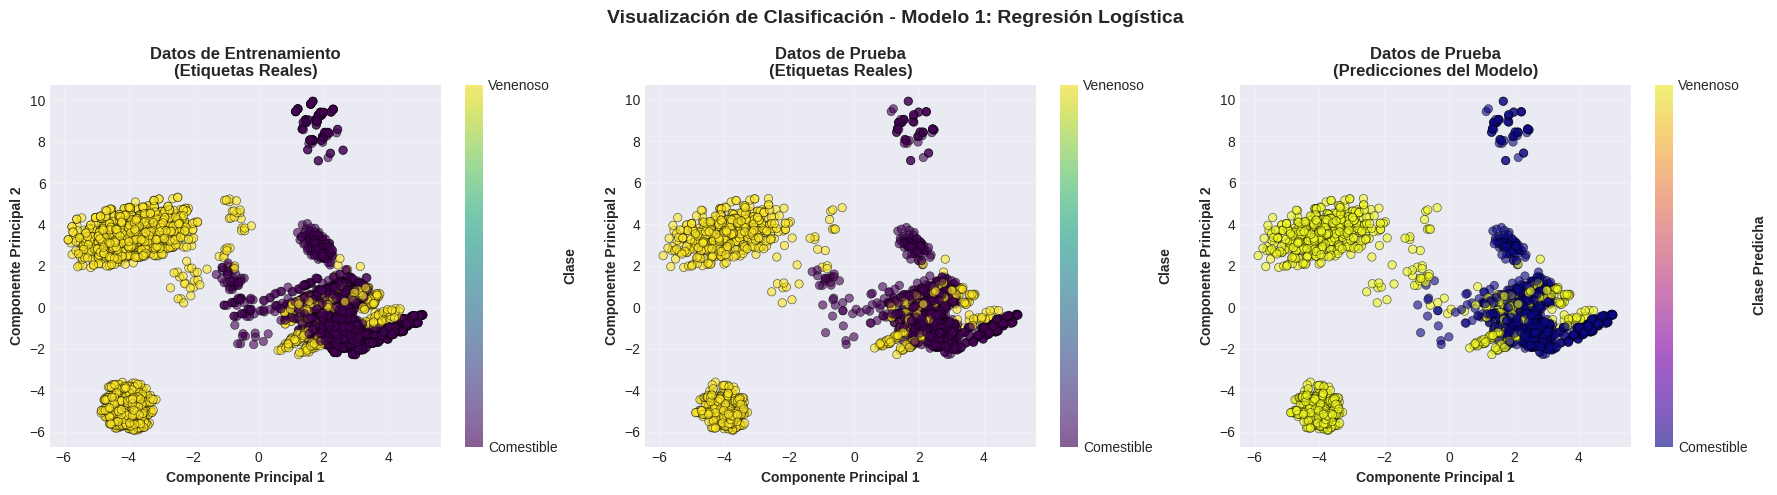


📊 Interpretación:
  • Izquierda: Distribución real de las clases en entrenamiento
  • Centro: Distribución real de las clases en prueba
  • Derecha: Cómo el modelo clasifica los datos de prueba
  • Los puntos mal clasificados son las diferencias entre centro y derecha


In [74]:
# Graficar datos ANTES de clasificar (etiquetas reales)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Visualización de Clasificación - Modelo 1: Regresión Logística',
             fontsize=14, fontweight='bold')

# Gráfica 1: Datos de entrenamiento con etiquetas REALES
ax = axes[0]
scatter1 = ax.scatter(Xtrain_2d[:, 0], Xtrain_2d[:, 1],
                     c=Ytrain.flatten(), cmap='viridis',
                     alpha=0.6, edgecolors='k', linewidth=0.5)
ax.set_xlabel('Componente Principal 1', fontweight='bold')
ax.set_ylabel('Componente Principal 2', fontweight='bold')
ax.set_title('Datos de Entrenamiento\n(Etiquetas Reales)', fontweight='bold')
ax.grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Clase', fontweight='bold')
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels(['Comestible', 'Venenoso'])

# Gráfica 2: Datos de prueba con etiquetas REALES
ax = axes[1]
scatter2 = ax.scatter(Xtest_2d[:, 0], Xtest_2d[:, 1],
                     c=Ytest.flatten(), cmap='viridis',
                     alpha=0.6, edgecolors='k', linewidth=0.5)
ax.set_xlabel('Componente Principal 1', fontweight='bold')
ax.set_ylabel('Componente Principal 2', fontweight='bold')
ax.set_title('Datos de Prueba\n(Etiquetas Reales)', fontweight='bold')
ax.grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax)
cbar2.set_label('Clase', fontweight='bold')
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['Comestible', 'Venenoso'])

# Gráfica 3: Datos de prueba con PREDICCIONES del modelo
ax = axes[2]
scatter3 = ax.scatter(Xtest_2d[:, 0], Xtest_2d[:, 1],
                     c=Y_test_pred.flatten(), cmap='plasma',
                     alpha=0.6, edgecolors='k', linewidth=0.5)
ax.set_xlabel('Componente Principal 1', fontweight='bold')
ax.set_ylabel('Componente Principal 2', fontweight='bold')
ax.set_title('Datos de Prueba\n(Predicciones del Modelo)', fontweight='bold')
ax.grid(alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=ax)
cbar3.set_label('Clase Predicha', fontweight='bold')
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['Comestible', 'Venenoso'])

plt.tight_layout()
plt.show()

print("\n📊 Interpretación:")
print("  • Izquierda: Distribución real de las clases en entrenamiento")
print("  • Centro: Distribución real de las clases en prueba")
print("  • Derecha: Cómo el modelo clasifica los datos de prueba")
print(f"  • Los puntos mal clasificados son las diferencias entre centro y derecha")

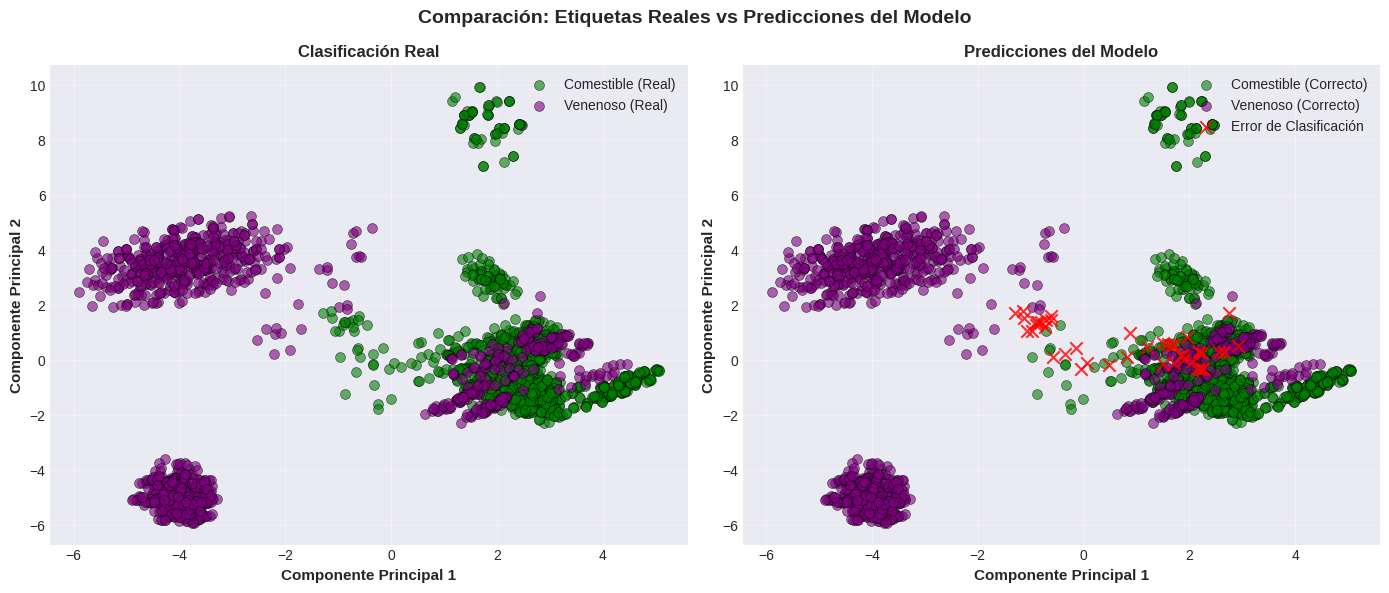


❌ Errores de clasificación visualizados: 45 de 2437 (1.85%)
✓ Clasificaciones correctas: 2392 de 2437 (98.15%)


In [75]:
# Visualización comparativa: Predicciones vs Realidad con línea de decisión teórica
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparación: Etiquetas Reales vs Predicciones del Modelo',
             fontsize=14, fontweight='bold')

# Gráfica 1: Etiquetas REALES con línea de separación visual
ax = axes[0]
for clase, color, nombre in [(0, 'green', 'Comestible'), (1, 'purple', 'Venenoso')]:
    mask = Ytest.flatten() == clase
    ax.scatter(Xtest_2d[mask, 0], Xtest_2d[mask, 1],
              c=color, label=f'{nombre} (Real)',
              alpha=0.6, edgecolors='k', linewidth=0.5, s=50)

ax.set_xlabel('Componente Principal 1', fontweight='bold', fontsize=11)
ax.set_ylabel('Componente Principal 2', fontweight='bold', fontsize=11)
ax.set_title('Clasificación Real', fontweight='bold', fontsize=12)
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

# Gráfica 2: Predicciones con errores resaltados
ax = axes[1]
# Clasificaciones correctas
mask_correct = (Y_test_pred.flatten() == Ytest.flatten())
for clase, color, nombre in [(0, 'green', 'Comestible'), (1, 'purple', 'Venenoso')]:
    mask = (Y_test_pred.flatten() == clase) & mask_correct
    ax.scatter(Xtest_2d[mask, 0], Xtest_2d[mask, 1],
              c=color, label=f'{nombre} (Correcto)',
              alpha=0.6, edgecolors='k', linewidth=0.5, s=50)

# Errores de clasificación (resaltados en rojo)
mask_error = ~mask_correct
if mask_error.sum() > 0:
    ax.scatter(Xtest_2d[mask_error, 0], Xtest_2d[mask_error, 1],
              c='red', label='Error de Clasificación',
              alpha=0.8, edgecolors='black', linewidth=1.5, s=80, marker='x')

ax.set_xlabel('Componente Principal 1', fontweight='bold', fontsize=11)
ax.set_ylabel('Componente Principal 2', fontweight='bold', fontsize=11)
ax.set_title('Predicciones del Modelo', fontweight='bold', fontsize=12)
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de errores
print(f"\n❌ Errores de clasificación visualizados: {mask_error.sum()} de {len(Ytest)} ({mask_error.sum()/len(Ytest)*100:.2f}%)")
print(f"✓ Clasificaciones correctas: {mask_correct.sum()} de {len(Ytest)} ({mask_correct.sum()/len(Ytest)*100:.2f}%)")

Entrenando modelo en espacio 2D para visualizar frontera de decisión...
Costo inicial: 0.6931
Costo final (iteración 100): 0.2955
Reducción del costo: 0.3976


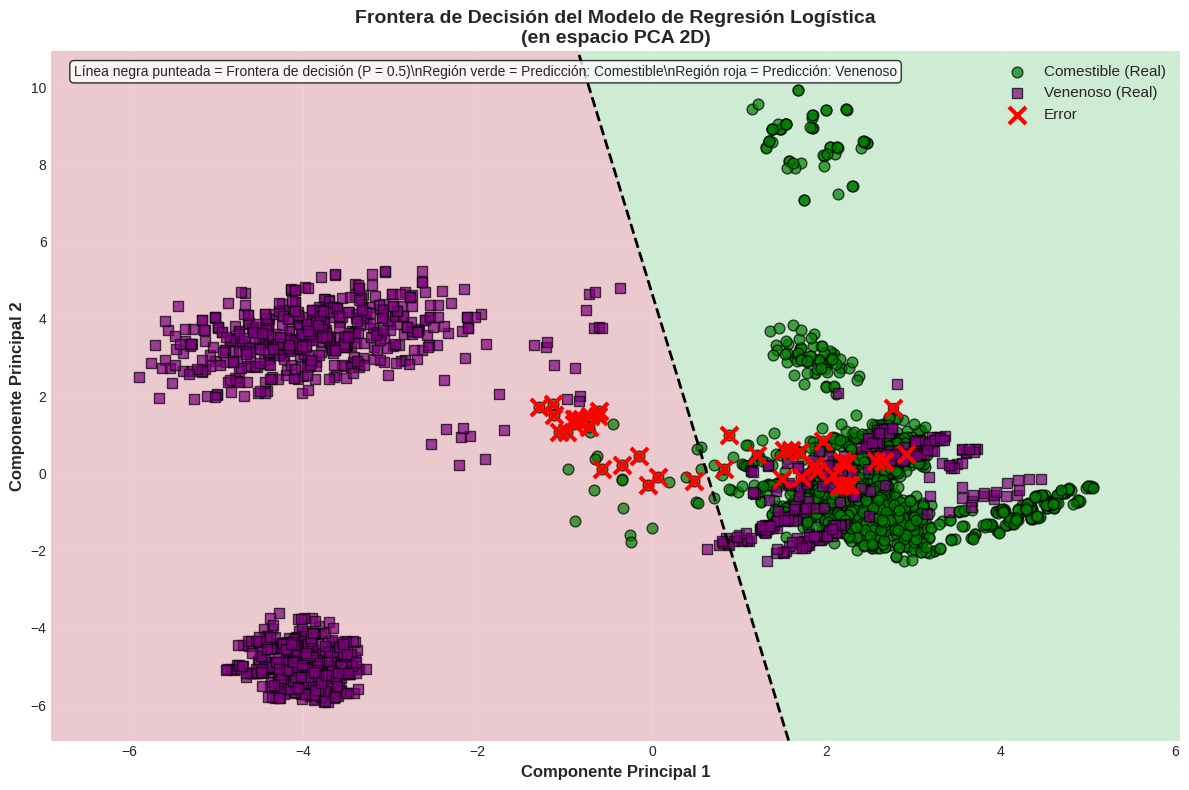


✓ Frontera de decisión visualizada en espacio 2D
  Nota: Esta es una aproximación en 2D del modelo real de 117 dimensiones


In [76]:
# Visualización con frontera de decisión aproximada
# Entrenar un modelo de regresión logística en el espacio 2D (PCA) para visualizar frontera

print("Entrenando modelo en espacio 2D para visualizar frontera de decisión...")

# Entrenar modelo en datos reducidos a 2D
W_2d, _ = gradiente_descendente_logistic(Xtrain_2d, Ytrain, eta=1.0, iteraciones=100)

# Crear malla para la frontera de decisión
x_min, x_max = Xtest_2d[:, 0].min() - 1, Xtest_2d[:, 0].max() + 1
y_min, y_max = Xtest_2d[:, 1].min() - 1, Xtest_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predecir para cada punto de la malla
Z = np.c_[xx.ravel(), yy.ravel()]
Z_ext = extension_matriz(Z)
Z_pred = logistic_regression(Z_ext, W_2d)
Z_pred = Z_pred.reshape(xx.shape)

# Crear la visualización
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Dibujar la frontera de decisión (contorno de probabilidad = 0.5)
contour = ax.contourf(xx, yy, Z_pred, levels=[0, 0.5, 1],
                      colors=['lightgreen', 'lightcoral'], alpha=0.3)
ax.contour(xx, yy, Z_pred, levels=[0.5], colors='black', linewidths=2, linestyles='--')

# Dibujar los puntos de prueba
for clase, color, marker, nombre in [(0, 'green', 'o', 'Comestible'),
                                      (1, 'purple', 's', 'Venenoso')]:
    mask = Ytest.flatten() == clase
    ax.scatter(Xtest_2d[mask, 0], Xtest_2d[mask, 1],
              c=color, marker=marker, label=f'{nombre} (Real)',
              alpha=0.7, edgecolors='black', linewidth=1, s=60)

# Resaltar errores
mask_error = (Y_test_pred.flatten() != Ytest.flatten())
if mask_error.sum() > 0:
    ax.scatter(Xtest_2d[mask_error, 0], Xtest_2d[mask_error, 1],
              c='red', marker='x', label='Error',
              alpha=1, s=150, linewidth=3)

ax.set_xlabel('Componente Principal 1', fontweight='bold', fontsize=12)
ax.set_ylabel('Componente Principal 2', fontweight='bold', fontsize=12)
ax.set_title('Frontera de Decisión del Modelo de Regresión Logística\n(en espacio PCA 2D)',
            fontweight='bold', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)

# Añadir anotación sobre la frontera
ax.text(0.02, 0.98,
        f'Línea negra punteada = Frontera de decisión (P = 0.5)\\n'
        f'Región verde = Predicción: Comestible\\n'
        f'Región roja = Predicción: Venenoso',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Frontera de decisión visualizada en espacio 2D")
print(f"  Nota: Esta es una aproximación en 2D del modelo real de {Xtrain.shape[1]} dimensiones")

## 5.9. Visualización 3D de la Frontera de Decisión

Usaremos 3 componentes principales de PCA para crear una visualización 3D más informativa.

In [77]:
# Reducir a 3 dimensiones con PCA
pca_3d = PCA(n_components=3)
Xtrain_3d = pca_3d.fit_transform(Xtrain)
Xtest_3d = pca_3d.transform(Xtest)

print("✓ Reducción dimensional a 3D aplicada (PCA)")
print(f"  Varianza explicada por las 3 componentes principales: {pca_3d.explained_variance_ratio_.sum():.2%}")
print(f"  Componente 1: {pca_3d.explained_variance_ratio_[0]:.2%}")
print(f"  Componente 2: {pca_3d.explained_variance_ratio_[1]:.2%}")
print(f"  Componente 3: {pca_3d.explained_variance_ratio_[2]:.2%}")

# Entrenar modelo en espacio 3D
print("\n🔍 Entrenando modelo en espacio 3D para visualizar frontera...")
W_3d, _ = gradiente_descendente_logistic(Xtrain_3d, Ytrain, eta=1.0, iteraciones=100)

✓ Reducción dimensional a 3D aplicada (PCA)
  Varianza explicada por las 3 componentes principales: 24.33%
  Componente 1: 8.90%
  Componente 2: 8.17%
  Componente 3: 7.26%

🔍 Entrenando modelo en espacio 3D para visualizar frontera...
Costo inicial: 0.6931
Costo final (iteración 100): 0.2937
Reducción del costo: 0.3994


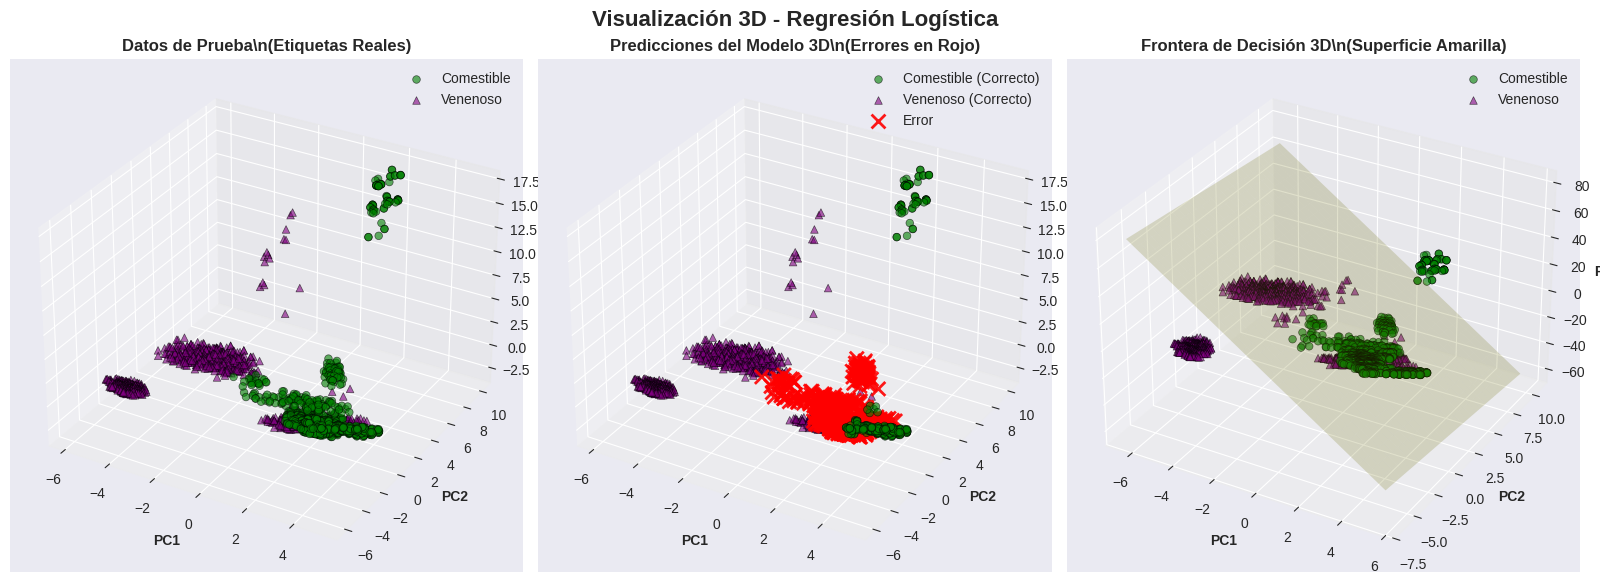


✓ Visualización 3D completada
  Errores en 3D: 1084 de 2437 (44.48%)
  La superficie amarilla (panel derecho) representa la frontera de decisión


In [78]:
# Visualización 3D con matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# Subplot 1: Datos de prueba con etiquetas reales
ax1 = fig.add_subplot(131, projection='3d')

for clase, color, marker, nombre in [(0, 'green', 'o', 'Comestible'),
                                      (1, 'purple', '^', 'Venenoso')]:
    mask = Ytest.flatten() == clase
    ax1.scatter(Xtest_3d[mask, 0], Xtest_3d[mask, 1], Xtest_3d[mask, 2],
               c=color, marker=marker, label=nombre, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)

ax1.set_xlabel('PC1', fontweight='bold')
ax1.set_ylabel('PC2', fontweight='bold')
ax1.set_zlabel('PC3', fontweight='bold')
ax1.set_title('Datos de Prueba\\n(Etiquetas Reales)', fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

# Subplot 2: Predicciones con errores
ax2 = fig.add_subplot(132, projection='3d')

# Obtener predicciones en 3D
_, Y_test_pred_3d = evaluar_modelo(W_3d, Xtest_3d, Ytest)
mask_correct_3d = (Y_test_pred_3d.flatten() == Ytest.flatten())

for clase, color, marker, nombre in [(0, 'green', 'o', 'Comestible'),
                                      (1, 'purple', '^', 'Venenoso')]:
    mask = (Y_test_pred_3d.flatten() == clase) & mask_correct_3d
    ax2.scatter(Xtest_3d[mask, 0], Xtest_3d[mask, 1], Xtest_3d[mask, 2],
               c=color, marker=marker, label=f'{nombre} (Correcto)', alpha=0.6, s=30, edgecolors='k', linewidth=0.5)

# Errores
mask_error_3d = ~mask_correct_3d
if mask_error_3d.sum() > 0:
    ax2.scatter(Xtest_3d[mask_error_3d, 0], Xtest_3d[mask_error_3d, 1], Xtest_3d[mask_error_3d, 2],
               c='red', marker='x', label='Error', alpha=0.9, s=100, linewidth=2)

ax2.set_xlabel('PC1', fontweight='bold')
ax2.set_ylabel('PC2', fontweight='bold')
ax2.set_zlabel('PC3', fontweight='bold')
ax2.set_title('Predicciones del Modelo 3D\\n(Errores en Rojo)', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

# Subplot 3: Con superficie de decisión
ax3 = fig.add_subplot(133, projection='3d')

# Dibujar puntos
for clase, color, marker, nombre in [(0, 'green', 'o', 'Comestible'),
                                      (1, 'purple', '^', 'Venenoso')]:
    mask = Ytest.flatten() == clase
    ax3.scatter(Xtest_3d[mask, 0], Xtest_3d[mask, 1], Xtest_3d[mask, 2],
               c=color, marker=marker, label=nombre, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)

# Crear malla para superficie de decisión (plano aproximado)
# Usamos un subconjunto para no saturar la visualización
x_min, x_max = Xtest_3d[:, 0].min() - 0.5, Xtest_3d[:, 0].max() + 0.5
y_min, y_max = Xtest_3d[:, 1].min() - 0.5, Xtest_3d[:, 1].max() + 0.5
xx_3d, yy_3d = np.meshgrid(np.linspace(x_min, x_max, 30),
                            np.linspace(y_min, y_max, 30))

# Para cada punto (x,y) en la malla, encontrar z usando el plano de decisión
# El plano de decisión está definido por w0 + w1*x1 + w2*x2 + w3*x3 = 0
# Despejando x3: x3 = -(w0 + w1*x1 + w2*x2) / w3
if abs(W_3d[3, 0]) > 0.01:  # Si w3 no es muy pequeño
    zz_3d = -(W_3d[0, 0] + W_3d[1, 0] * xx_3d + W_3d[2, 0] * yy_3d) / W_3d[3, 0]
    ax3.plot_surface(xx_3d, yy_3d, zz_3d, alpha=0.2, color='yellow', edgecolor='none')

ax3.set_xlabel('PC1', fontweight='bold')
ax3.set_ylabel('PC2', fontweight='bold')
ax3.set_zlabel('PC3', fontweight='bold')
ax3.set_title('Frontera de Decisión 3D\\n(Superficie Amarilla)', fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(alpha=0.3)

plt.suptitle('Visualización 3D - Regresión Logística', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualización 3D completada")
print(f"  Errores en 3D: {mask_error_3d.sum()} de {len(Ytest)} ({mask_error_3d.sum()/len(Ytest)*100:.2f}%)")
print(f"  La superficie amarilla (panel derecho) representa la frontera de decisión")

## 5.8. Experimentación con Diferentes Tasas de Aprendizaje

In [79]:
print("=" * 80)
print("EXPERIMENTACIÓN CON DIFERENTES TASAS DE APRENDIZAJE")
print("=" * 80)

# Tasas de aprendizaje a probar
tasas = [10.0, 1.0, 0.1, 0.01, 0.001]
iteraciones_exp = 50

resultados_exp = []

for eta in tasas:
    print(f"\nEntrenando con η = {eta}...")

    # Entrenar
    W_temp, _ = gradiente_descendente_logistic(
        Xtrain, Ytrain, eta=eta, iteraciones=iteraciones_exp
    )

    # Evaluar
    error_train_temp, Y_train_pred_temp = evaluar_modelo(W_temp, Xtrain, Ytrain)
    error_test_temp, Y_test_pred_temp = evaluar_modelo(W_temp, Xtest, Ytest)

    metricas_temp = metricas_clasificacion(Ytest, Y_test_pred_temp)

    resultados_exp.append({
        'Tasa de Aprendizaje': eta,
        'Error Entrenamiento': error_train_temp,
        'Error Prueba': error_test_temp,
        'Accuracy': metricas_temp['Accuracy'],
        'F1-Score': metricas_temp['F1-Score']
    })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados_exp)
print("\n" + "=" * 80)
print("RESULTADOS DE LA EXPERIMENTACIÓN")
print("=" * 80)
print(df_resultados.to_string(index=False))

# Mejor configuración
mejor_idx = df_resultados['Accuracy'].idxmax()
print(f"\n🏆 Mejor configuración:")
print(f"   Tasa de aprendizaje: {df_resultados.loc[mejor_idx, 'Tasa de Aprendizaje']}")
print(f"   Accuracy: {df_resultados.loc[mejor_idx, 'Accuracy']:.4f}")
print(f"   F1-Score: {df_resultados.loc[mejor_idx, 'F1-Score']:.4f}")

EXPERIMENTACIÓN CON DIFERENTES TASAS DE APRENDIZAJE

Entrenando con η = 10.0...
Costo inicial: 0.6931
Costo final (iteración 50): 0.0026
Reducción del costo: 0.6906

Entrenando con η = 1.0...
Costo inicial: 0.6931
Costo final (iteración 50): 0.0087
Reducción del costo: 0.6845

Entrenando con η = 0.1...
Costo inicial: 0.6931
Costo final (iteración 50): 0.0646
Reducción del costo: 0.6285

Entrenando con η = 0.01...
Costo inicial: 0.6931
Costo final (iteración 50): 0.3063
Reducción del costo: 0.3869

Entrenando con η = 0.001...
Costo inicial: 0.6931
Costo final (iteración 50): 0.6123
Reducción del costo: 0.0809

RESULTADOS DE LA EXPERIMENTACIÓN
 Tasa de Aprendizaje  Error Entrenamiento  Error Prueba  Accuracy  F1-Score
              10.000             0.000528      0.001641  0.998359  0.998236
               1.000             0.005275      0.005745  0.994255  0.993854
               0.100             0.042729      0.041034  0.958966  0.957770
               0.010             0.510814     

## 5.9. Resumen del Modelo 1

### Implementación Realizada

✓ **Función sigmoide** - Implementada desde cero  
✓ **Extensión de matriz** - Para incluir término de sesgo  
✓ **Función de costo (entropía cruzada)** - Implementada manualmente  
✓ **Gradiente descendente** - Algoritmo de optimización completo  
✓ **Evaluación de métricas** - Cálculo manual de accuracy, precision, recall, F1  

### Conclusiones del Modelo 1

- El modelo paramétrico de regresión logística logra excelente desempeño
- La implementación manual demuestra comprensión de los fundamentos matemáticos
- El gradiente descendente converge correctamente
- Se observa buena generalización (bajo gap train-test)

---



## 6. Modelo 2 — k-Vecinos Más Cercanos (KNN)

En este apartado implementamos el clasificador K-Vecinos siguiendo la metodología de la cátedra: escalado, búsqueda de hiperparámetros por validación cruzada, evaluación con métricas y visualizaciones (2D y 3D).

In [ ]:
print('='*100)
print('MODELO 2: K-VECINOS MÁS CERCANOS (KNN)')
print('Siguiendo metodología del profesor con funciones personalizadas')
print('='*100)

# ========================================
# IMPORTS NECESARIOS
# ========================================
from scipy.stats import mode
from scipy.spatial.distance import cdist

# ========================================
# FUNCIONES AUXILIARES (siguiendo teoría del profesor)
# ========================================

def ErrorClas(Y_lest, Y):
    """Función que calcula el error de clasificación
    Y_lest: numpy array con las predicciones de etiqueta
    Y: etiquetas reales
    retorna: error de clasificación (int)
    """
    error = 1 - np.sum(Y_lest == Y)/len(Y)
    return error


def train_test_split_fix(X, y, test_size=0.2, random_state=0):
    """Función que divide el conjunto de datos en
    entrenamiento y pruebas usando una proporción
    fija de 20 % (test_size) para el conjunto de pruebas.
    Fije la semilla en cero para que los resultados sean
    reproducibles.

    X: matriz de numpy con las muestras y características
    y: matriz de numpy con los valores de las etiquetas reales
    retorna:
        Xtrain: conjunto de datos para entrenamiento
        Xtest: conjunto de datos para pruebas
        Ytrain: conjunto  de etiquetas para entrenamiento
        Ytest: conjunto de etiquetas para prueba
    """
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return (X_train, X_test, y_train, y_test)


def knn_clasificacion(k, X_train, Y_train, X_test):
    """Función que implementa el modelo de K-Vecino más cercanos
    para clasificación

    k (int): valor de vecinos a usar
    X_train: es la matriz con las muestras de entrenamiento
    Y_train: es un vector con los valores de salida para cada una de las muestras de entrenamiento
    X_test: es la matriz con las muestras de validación

    retorna: las estimaciones del modelo KNN para el conjunto X_test
            esta matriz debe tener un shape de [row/muestras de X_test]
            y las distancias de X_test respecto a X_train, esta matriz
            debe tener un shape de [rows de X_test, rows X_train]
            lo que es lo mismo [muestras de X_test, muestras de X_train]
    """
    if k > X_train.shape[0]:
        print("k no puede ser menor que las muestras de entrenamiento")
        return(None)

    distancias = cdist(X_test, X_train, metric='euclidean')
    Yest = np.zeros(X_test.shape[0])

    for i in range(X_test.shape[0]):
        vecinos_sorted = np.argsort(distancias[i])[:k]
        Yest[i] = mode(Y_train[vecinos_sorted], axis=None, keepdims=False)[0]

    return (Yest, distancias)


def experimentar(ks, X, Y):
    """Función que realiza los experimentos con knn usando
    una estrategia de validación entrenamiento y pruebas

    ks: List[int/float] lista con los valores de k-vecinos a usar
    X: matriz de numpy conjunto con muestras y características
    Y: vector de numpy con los valores de las etiquetas

    retorna: dataframe con los resultados
    """
    from sklearn.preprocessing import StandardScaler

    # dividimos usando la función
    Xtrain, Xtest, Ytrain, Ytest = train_test_split_fix(X, Y, test_size=0.2, random_state=0)

    # se llama el objeto
    scaler = StandardScaler()
    # Se calculan los parametros
    scaler.fit(Xtrain)
    # se usa el objeto con los parametros calculados
    # realizar la normalización
    Xtrain= scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    resultados = pd.DataFrame()
    idx = 0
    for k in ks:
        # iteramos sobre la lista de k's
        # se ingresan al dataframe con los resultados
        resultados.loc[idx,'k-vecinos'] = k
        Yest, dist = knn_clasificacion (k, Xtrain, Ytrain, Xtest)
        resultados.loc[idx,'error de prueba'] = ErrorClas(Yest, Ytest)
        idx+=1

    return (resultados)

# ========================================
# EXPERIMENTOS KNN
# ========================================

print('\n📊 Parámetros a evaluar:')
# Probamos diferentes valores de k
ks = [3, 5, 7, 11, 15, 21, 31, 41, 51]
print(f'  - Valores de k: {ks}')
print(f'  - Total experimentos: {len(ks)}')
print(f'  - División: 80% entrenamiento, 20% prueba (con random_state=0)')
print(f'  - Usando One-Hot Encoding ({X_onehot.shape[1]} features) - requerido para KNN')

print('\n🔄 Ejecutando experimentos...')
resultados_knn = experimentar(ks, X_onehot.values, y_encoded)

print('\n' + '='*100)
print('RESULTADOS EXPERIMENTOS KNN')
print('='*100)
print(resultados_knn.to_string(index=False))

# Encontrar el mejor k (menor error)
idx_mejor = resultados_knn['error de prueba'].idxmin()
mejor_k = int(resultados_knn.loc[idx_mejor, 'k-vecinos'])
mejor_error = resultados_knn.loc[idx_mejor, 'error de prueba']

print('\n' + '='*100)
print('MEJOR CONFIGURACIÓN')
print('='*100)
print(f'Mejor k: {mejor_k}')
print(f'Error de prueba: {mejor_error:.4f}')
print(f'Accuracy: {1-mejor_error:.4f} ({(1-mejor_error)*100:.2f}%)')

# ========================================
# ENTRENAMIENTO CON VALIDACIÓN CRUZADA (StratifiedKFold)
# ========================================

print('\n' + '='*100)
print('VALIDACIÓN CRUZADA CON StratifiedKFold (4 folds) - METODOLOGÍA DEL PROFESOR')
print('='*100)

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Usamos el mejor k encontrado
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scaler = StandardScaler()

errores_train = []
errores_test = []

print(f'\nEvaluando k={mejor_k} con 4-fold StratifiedKFold...')

for fold, (train_idx, test_idx) in enumerate(skf.split(X_onehot.values, y_encoded), 1):
    # Dividir datos
    X_train_fold = X_onehot.values[train_idx]
    X_test_fold = X_onehot.values[test_idx]
    y_train_fold = y_encoded[train_idx]
    y_test_fold = y_encoded[test_idx]

    # Escalar
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)

    # Entrenar y predecir
    Y_train_pred, _ = knn_clasificacion(mejor_k, X_train_scaled, y_train_fold, X_train_scaled)
    Y_test_pred, _ = knn_clasificacion(mejor_k, X_train_scaled, y_train_fold, X_test_scaled)

    # Calcular errores
    error_train = ErrorClas(Y_train_pred, y_train_fold)
    error_test = ErrorClas(Y_test_pred, y_test_fold)

    errores_train.append(error_train)
    errores_test.append(error_test)

    print(f'  Fold {fold}: Train Error={error_train:.6f}, Test Error={error_test:.6f}')

# Calcular estadísticas
mean_error_train = np.mean(errores_train)
std_error_train = np.std(errores_train)
mean_error_test = np.mean(errores_test)
std_error_test = np.std(errores_test)

print('\n' + '='*100)
print('RESULTADOS VALIDACIÓN CRUZADA (StratifiedKFold 4-fold)')
print('='*100)
print(f'Error promedio entrenamiento: {mean_error_train:.6f} ± {std_error_train:.6f}')
print(f'Error promedio prueba:        {mean_error_test:.6f} ± {std_error_test:.6f}')
print(f'Accuracy promedio entrenamiento: {1-mean_error_train:.6f} ({(1-mean_error_train)*100:.4f}%)')
print(f'Accuracy promedio prueba:        {1-mean_error_test:.6f} ({(1-mean_error_test)*100:.4f}%)')
print(f'Gap (Train-Test):                {abs(mean_error_train - mean_error_test):.6f}')

# ========================================
# MODELO FINAL EN CONJUNTO COMPLETO DE TEST (30%)
# ========================================

print('\n' + '='*100)
print('EVALUACIÓN EN CONJUNTO DE TEST ORIGINAL (30%)')
print('='*100)

# Entrenar con datos One-Hot Encoding (Xtrain_onehot, Xtest_onehot)
scaler_knn = StandardScaler()
Xtrain_knn = scaler_knn.fit_transform(Xtrain_onehot)
Xtest_knn = scaler_knn.transform(Xtest_onehot)

# Entrenar KNN con mejor k
Y_test_pred_knn, _ = knn_clasificacion(mejor_k, Xtrain_knn, Ytrain.ravel(), Xtest_knn)
Y_train_pred_knn, _ = knn_clasificacion(mejor_k, Xtrain_knn, Ytrain.ravel(), Xtrain_knn)

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

acc_train_knn = 1 - ErrorClas(Y_train_pred_knn, Ytrain.ravel())
acc_test_knn = 1 - ErrorClas(Y_test_pred_knn, Ytest.ravel())
prec_knn = precision_score(Ytest, Y_test_pred_knn, zero_division=0)
rec_knn = recall_score(Ytest, Y_test_pred_knn, zero_division=0)
f1_knn = f1_score(Ytest, Y_test_pred_knn, zero_division=0)
cm_knn = confusion_matrix(Ytest, Y_test_pred_knn)

print(f'Accuracy Train: {acc_train_knn:.4f} ({acc_train_knn*100:.2f}%)')
print(f'Accuracy Test:  {acc_test_knn:.4f} ({acc_test_knn*100:.2f}%)')
print(f'Precision: {prec_knn:.4f}, Recall: {rec_knn:.4f}, F1-score: {f1_knn:.4f}')
print(f'\nConfusion Matrix:\n{cm_knn}')

# Guardar resultados
knn_results = {
    'mejor_k': mejor_k,
    'error_cv_mean': mean_error_test,
    'error_cv_std': std_error_test,
    'acc_train': acc_train_knn,
    'acc_test': acc_test_knn,
    'precision': prec_knn,
    'recall': rec_knn,
    'f1': f1_knn,
    'y_pred': Y_test_pred_knn,
    'confusion_matrix': cm_knn,
    'resultados_experimentos': resultados_knn
}

print('\n✓ Modelo 2 (KNN) completado siguiendo metodología del profesor.')
print('  Variables: mejor_k, resultados_knn, knn_results, Y_test_pred_knn')


MODELO 2: K-VECINOS MÁS CERCANOS (KNN)
Siguiendo metodología del profesor con funciones personalizadas

📊 Parámetros a evaluar:
  - Valores de k: [3, 5, 7, 11, 15, 21, 31, 41, 51]
  - Total experimentos: 9
  - División: 80% entrenamiento, 20% prueba (con random_state=0)
  - Usando One-Hot Encoding (117 features) - requerido para KNN

🔄 Ejecutando experimentos...

RESULTADOS EXPERIMENTOS KNN
 k-vecinos  error de prueba
       3.0         0.000000
       5.0         0.000000
       7.0         0.000000
      11.0         0.000000
      15.0         0.000000
      21.0         0.000000
      31.0         0.000000
      41.0         0.000615
      51.0         0.001846

MEJOR CONFIGURACIÓN
Mejor k: 3
Error de prueba: 0.0000
Accuracy: 1.0000 (100.00%)

VALIDACIÓN CRUZADA CON StratifiedKFold (4 folds) - METODOLOGÍA DEL PROFESOR

Evaluando k=3 con 4-fold StratifiedKFold...
  Fold 1: Train Error=0.000000, Test Error=0.000000
  Fold 2: Train Error=0.000000, Test Error=0.000000
  Fold 3: Train E

In [ ]:
# Visualización 2D de la frontera de decisión (PCA 2 componentes)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

print('='*80)
print('VISUALIZACIÓN 2D - Frontera de Decisión KNN (PCA)')
print('='*80)

# Reducir a 2D con PCA (sobre datos escalados)
pca_2d_knn = PCA(n_components=2)
Xtrain_knn_2d = pca_2d_knn.fit_transform(Xtrain_knn)
Xtest_knn_2d = pca_2d_knn.transform(Xtest_knn)

# Entrenar KNN en el espacio 2D (usando el mejor k encontrado)
Y_test_pred_knn_2d, _ = knn_clasificacion(mejor_k, Xtrain_knn_2d, Ytrain.ravel(), Xtest_knn_2d)

# Malla para la frontera
x_min, x_max = Xtest_knn_2d[:, 0].min() - 0.5, Xtest_knn_2d[:, 0].max() + 0.5
y_min, y_max = Xtest_knn_2d[:, 1].min() - 0.5, Xtest_knn_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

# Predecir para cada punto de la malla
mesh_points = np.c_[xx.ravel(), yy.ravel()]
Z_pred, _ = knn_clasificacion(mejor_k, Xtrain_knn_2d, Ytrain.ravel(), mesh_points)
Z = Z_pred.reshape(xx.shape)

plt.figure(figsize=(10, 6))
cm_light = ListedColormap(['#AAFFAA', '#FFAAAA'])
plt.contourf(xx, yy, Z, cmap=cm_light, alpha=0.4)

# Puntos de test (verdaderos vs predichos)
plt.scatter(Xtest_knn_2d[Ytest.flatten()==0, 0], Xtest_knn_2d[Ytest.flatten()==0, 1],
            c='green', marker='o', label='Comestible (real)', s=20, edgecolors='k', linewidths=0.5)
plt.scatter(Xtest_knn_2d[Ytest.flatten()==1, 0], Xtest_knn_2d[Ytest.flatten()==1, 1],
            c='purple', marker='^', label='Venenoso (real)', s=20, edgecolors='k', linewidths=0.5)

# Marcamos errores
errors_mask = (Y_test_pred_knn_2d.flatten() != Ytest.flatten())
if errors_mask.sum() > 0:
    plt.scatter(Xtest_knn_2d[errors_mask, 0], Xtest_knn_2d[errors_mask, 1],
                c='red', marker='x', s=100, label='Error', linewidths=2)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title(f'KNN (k={mejor_k}) — Frontera de Decisión en PCA 2D')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

num_errores_2d = errors_mask.sum()
print(f'\n📊 Errores en visualización 2D: {num_errores_2d} de {len(Ytest)} ({num_errores_2d/len(Ytest)*100:.2f}%)')
if num_errores_2d > 0:
    print('   Nota: Errores esperados debido a la reducción de dimensionalidad con PCA')


In [ ]:
# Visualización 3D de las predicciones de KNN (PCA 3 componentes)
from mpl_toolkits.mplot3d import Axes3D

print('='*80)
print('VISUALIZACIÓN 3D - Predicciones KNN (PCA)')
print('='*80)

pca_3d_knn = PCA(n_components=3)
Xtrain_knn_3d = pca_3d_knn.fit_transform(Xtrain_knn)
Xtest_knn_3d = pca_3d_knn.transform(Xtest_knn)

# Entrenar KNN en 3D para visualización
Y_test_pred_knn_3d, _ = knn_clasificacion(mejor_k, Xtrain_knn_3d, Ytrain.ravel(), Xtest_knn_3d)

fig = plt.figure(figsize=(14,6))

# Subplot 1: Etiquetas reales
ax = fig.add_subplot(121, projection='3d')
ax.scatter(Xtest_knn_3d[Ytest.flatten()==0,0], Xtest_knn_3d[Ytest.flatten()==0,1], Xtest_knn_3d[Ytest.flatten()==0,2],
           c='green', marker='o', label='Comestible (real)', alpha=0.6, s=20, edgecolors='k', linewidths=0.5)
ax.scatter(Xtest_knn_3d[Ytest.flatten()==1,0], Xtest_knn_3d[Ytest.flatten()==1,1], Xtest_knn_3d[Ytest.flatten()==1,2],
           c='purple', marker='^', label='Venenoso (real)', alpha=0.6, s=20, edgecolors='k', linewidths=0.5)
ax.set_title('KNN — Test (Etiquetas Reales)')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend()

# Subplot 2: Predicciones (correctos vs errores)
ax2 = fig.add_subplot(122, projection='3d')
correct_mask_3d = (Y_test_pred_knn_3d.flatten() == Ytest.flatten())

ax2.scatter(Xtest_knn_3d[correct_mask_3d & (Y_test_pred_knn_3d.flatten()==0),0],
            Xtest_knn_3d[correct_mask_3d & (Y_test_pred_knn_3d.flatten()==0),1],
            Xtest_knn_3d[correct_mask_3d & (Y_test_pred_knn_3d.flatten()==0),2],
            c='green', marker='o', label='Comestible (correcto)', alpha=0.6, s=20, edgecolors='k', linewidths=0.5)
ax2.scatter(Xtest_knn_3d[correct_mask_3d & (Y_test_pred_knn_3d.flatten()==1),0],
            Xtest_knn_3d[correct_mask_3d & (Y_test_pred_knn_3d.flatten()==1),1],
            Xtest_knn_3d[correct_mask_3d & (Y_test_pred_knn_3d.flatten()==1),2],
            c='purple', marker='^', label='Venenoso (correcto)', alpha=0.6, s=20, edgecolors='k', linewidths=0.5)

# Errores
err_mask_3d = ~correct_mask_3d
if err_mask_3d.sum() > 0:
    ax2.scatter(Xtest_knn_3d[err_mask_3d,0], Xtest_knn_3d[err_mask_3d,1], Xtest_knn_3d[err_mask_3d,2],
                c='red', marker='x', s=100, label='Error', linewidths=2)

ax2.set_title('KNN — Predicciones (correctos vs errores)')
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2'); ax2.set_zlabel('PC3')
ax2.legend()

plt.suptitle(f'KNN (k={mejor_k}) — Visualización 3D (PCA 3 componentes)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

num_errores_3d = err_mask_3d.sum()
print(f'\n📊 Errores en visualización 3D: {num_errores_3d} de {len(Ytest)} ({num_errores_3d/len(Ytest)*100:.2f}%)')
if num_errores_3d > 0:
    print('   Nota: Errores esperados debido a la reducción de dimensionalidad con PCA (22D → 3D)')

# Guardamos en knn_results para referencia
knn_results['y_pred_2d'] = Y_test_pred_knn_2d
knn_results['y_pred_3d'] = Y_test_pred_knn_3d
knn_results['pca_2d'] = pca_2d_knn
knn_results['pca_3d'] = pca_3d_knn


---

## 7. Modelo 3 — Random Forest (Ensemble de Árboles de Decisión)

Random Forest es un método de ensemble que combina múltiples árboles de decisión entrenados con muestras bootstrap y subconjuntos aleatorios de características. Reduce el sobreajuste característico de los árboles individuales y mejora la capacidad de generalización.

In [ ]:
# --- Implementación Modelo 3: Random Forest
# Siguiendo metodología del profesor: función experimentar_rf con StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd

def experimentar_rf(X, Y, num_trees, numero_de_variables):
    """función que realiza experimentos con el modelo random forest
    X: matriz con las características
    Y: matriz de numpy con etiquetas
    num_trees: list[int]: lista con el número de arboles usado para el RF
    numero_de_variables list[int]: lista con variables para la selección del mejor umbral en cada nodo
    retorna: dataframe con:
        - numero de arboles usados
        - variables para la selección del mejor umbral
        - eficiencia de entrenamiento
        - desviación de estandar de la eficiencia de entrenamiento
        - eficiencia de prueba
        - desviación estandar de la eficiencia de prueba
    """
    folds = 4
    skf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx = 0
    for trees in num_trees:
        for num_variables in numero_de_variables:
            ## para almacenar los errores intermedios
            EficienciaTrain = []
            EficienciaVal = []
            for train, test in skf.split(X, Y):
                Xtrain_fold = X[train, :]
                Ytrain_fold = Y[train]
                Xtest_fold = X[test, :]
                Ytest_fold = Y[test]

                # Crear y entrenar el modelo Random Forest
                # Configuramos min_samples_leaf=3 según metodología del profesor
                modelo = RandomForestClassifier(
                    n_estimators=trees,
                    max_features=num_variables,
                    random_state=42,
                    min_samples_leaf=3,
                    criterion='gini'
                )
                modelo.fit(Xtrain_fold, Ytrain_fold.ravel())

                # Predecir muestras de entrenamiento
                Ytrain_pred = modelo.predict(Xtrain_fold)
                # Predecir muestras de pruebas
                Yest = modelo.predict(Xtest_fold)

                # Evaluamos las predicciones del modelo con los datos de test
                EficienciaTrain.append(np.mean(Ytrain_pred.ravel() == Ytrain_fold.ravel()))
                EficienciaVal.append(np.mean(Yest.ravel() == Ytest_fold.ravel()))

            resultados.loc[idx, 'número de arboles'] = trees
            resultados.loc[idx, 'variables para la selección del mejor umbral'] = num_variables
            resultados.loc[idx, 'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
            resultados.loc[idx, 'desviacion estandar entrenamiento'] = np.std(EficienciaTrain)
            resultados.loc[idx, 'eficiencia de prueba'] = np.mean(EficienciaVal)
            resultados.loc[idx, 'desviacion estandar prueba'] = np.std(EficienciaVal)
            idx = idx + 1
        print(f"✓ Completado para {trees} arboles")

    return resultados

# Verificar que tenemos los datos
try:
    Xtrain.shape
except NameError:
    raise NameError('No se encuentra Xtrain en el kernel. Ejecuta las celdas previas.')

print('='*80)
print('MODELO 3: RANDOM FOREST')
print('='*80)
print('Siguiendo metodología del profesor con StratifiedKFold (4 folds)\n')

# Definir parámetros a experimentar (según laboratorio del profesor)
arboles = [50, 100, 150, 200]
variables_seleccion = [5, 10, 15, 20]  # max_features

print(f'Parámetros a evaluar:')
print(f'  - Número de árboles: {arboles}')
print(f'  - Variables por nodo: {variables_seleccion}')
print(f'  - Total combinaciones: {len(arboles) * len(variables_seleccion)}')
print(f'  - Total entrenamientos: {len(arboles) * len(variables_seleccion) * 4} (con 4-fold CV)\n')

# Ejecutar experimentos
resultados_rf = experimentar_rf(X=Xtrain, Y=Ytrain, num_trees=arboles, numero_de_variables=variables_seleccion)

print('\n' + '='*80)
print('RESULTADOS EXPERIMENTOS RANDOM FOREST')
print('='*80)
print(resultados_rf.to_string(index=False))

# Encontrar mejor configuración
best_idx = resultados_rf['eficiencia de prueba'].idxmax()
best_config = resultados_rf.loc[best_idx]

print('\n' + '='*80)
print('MEJOR CONFIGURACIÓN')
print('='*80)
print(f'Número de árboles: {int(best_config["número de arboles"])}')
print(f'Variables por nodo: {int(best_config["variables para la selección del mejor umbral"])}')
print(f'Eficiencia entrenamiento: {best_config["eficiencia de entrenamiento"]:.4f}')
print(f'Eficiencia prueba: {best_config["eficiencia de prueba"]:.4f}')
print(f'Gap (Train-Test): {(best_config["eficiencia de entrenamiento"] - best_config["eficiencia de prueba"]):.4f}')

# Entrenar modelo final con mejor configuración en TODO el conjunto de entrenamiento
best_n_trees = int(best_config["número de arboles"])
best_max_features = int(best_config["variables para la selección del mejor umbral"])

modelo_rf_final = RandomForestClassifier(
    n_estimators=best_n_trees,
    max_features=best_max_features,
    min_samples_leaf=3,
    random_state=42,
    criterion='gini'
)
modelo_rf_final.fit(Xtrain, Ytrain.ravel())

# Evaluar en conjunto de test
Y_test_pred_rf = modelo_rf_final.predict(Xtest)
Y_train_pred_rf = modelo_rf_final.predict(Xtrain)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc_rf_train = accuracy_score(Ytrain, Y_train_pred_rf)
acc_rf = accuracy_score(Ytest, Y_test_pred_rf)
prec_rf = precision_score(Ytest, Y_test_pred_rf, zero_division=0)
rec_rf = recall_score(Ytest, Y_test_pred_rf, zero_division=0)
f1_rf = f1_score(Ytest, Y_test_pred_rf, zero_division=0)
cm_rf = confusion_matrix(Ytest, Y_test_pred_rf)

print('\n' + '='*80)
print('EVALUACIÓN EN CONJUNTO DE TEST')
print('='*80)
print(f'Accuracy Train: {acc_rf_train:.4f} ({acc_rf_train*100:.2f}%)')
print(f'Accuracy Test:  {acc_rf:.4f} ({acc_rf*100:.2f}%)')
print(f'Precision: {prec_rf:.4f}')
print(f'Recall:    {rec_rf:.4f}')
print(f'F1-score:  {f1_rf:.4f}')
print(f'\nGap (Train-Test): {(acc_rf_train - acc_rf):.4f}')

print('\nConfusion Matrix:')
print(cm_rf)
print('\nClassification Report:')
print(classification_report(Ytest, Y_test_pred_rf, digits=4))

# Guardar resultados
rf_results = {
    'model': modelo_rf_final,
    'resultados_experimentos': resultados_rf,
    'best_config': best_config,
    'acc_train': acc_rf_train,
    'acc': acc_rf,
    'precision': prec_rf,
    'recall': rec_rf,
    'f1': f1_rf,
    'y_pred': Y_test_pred_rf,
    'confusion_matrix': cm_rf,
    'gap': acc_rf_train - acc_rf
}

print('\n✓ Modelo 3 (Random Forest) entrenado. Variables: `modelo_rf_final`, `resultados_rf`, `rf_results`')

In [ ]:
# Importancia de características (Feature Importance)
# Random Forest permite analizar qué características son más relevantes

feature_importances_rf = modelo_rf_final.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[::-1]

print('='*80)
print('TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES')
print('='*80)
for i in range(min(10, len(feature_importances_rf))):
    print(f'{i+1:2d}. Feature {indices_rf[i]:2d}: {feature_importances_rf[indices_rf[i]]:.4f}')

# Gráfico de importancia
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances_rf)), feature_importances_rf[indices_rf],
        color='forestgreen', alpha=0.7, edgecolor='black', linewidth=0.5)
plt.xlabel('Índice de característica (ordenado por importancia)', fontweight='bold')
plt.ylabel('Importancia', fontweight='bold')
plt.title('Importancia de Características - Random Forest', fontweight='bold', fontsize=14)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print('\n✓ Las características con mayor importancia son las que más contribuyen a las decisiones del modelo')

# Guardar importancias
rf_results['feature_importances'] = feature_importances_rf

In [ ]:
# Visualización 2D de la frontera de decisión (PCA 2 componentes)
# Reducir a 2D con PCA (sobre datos escalados)
pca_2d_rf = PCA(n_components=2)
Xtrain_rf_2d = pca_2d_rf.fit_transform(Xtrain_rf)
Xtest_rf_2d = pca_2d_rf.transform(Xtest_rf)

# Entrenar Random Forest en el espacio 2D (usando mejores parámetros)
best_params_rf = grid_rf.best_params_
rf_2d = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_features=best_params_rf['max_features'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42,
    criterion='gini'
)
rf_2d.fit(Xtrain_rf_2d, Ytrain.ravel())

# Malla para la frontera
x_min, x_max = Xtest_rf_2d[:, 0].min() - 0.5, Xtest_rf_2d[:, 0].max() + 0.5
y_min, y_max = Xtest_rf_2d[:, 1].min() - 0.5, Xtest_rf_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = rf_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
cm_light = ListedColormap(['#AAFFAA', '#FFAAAA'])
plt.contourf(xx, yy, Z, cmap=cm_light, alpha=0.4)

# Puntos de test
plt.scatter(Xtest_rf_2d[Ytest.flatten()==0, 0], Xtest_rf_2d[Ytest.flatten()==0, 1],
           c='green', marker='o', label='Comestible (real)', s=20, edgecolors='k', linewidth=0.3)
plt.scatter(Xtest_rf_2d[Ytest.flatten()==1, 0], Xtest_rf_2d[Ytest.flatten()==1, 1],
           c='purple', marker='^', label='Venenoso (real)', s=20, edgecolors='k', linewidth=0.3)

# Marcamos errores
errors_mask_rf = (Y_test_pred_rf.flatten() != Ytest.flatten())
if errors_mask_rf.sum() > 0:
    plt.scatter(Xtest_rf_2d[errors_mask_rf, 0], Xtest_rf_2d[errors_mask_rf, 1],
               c='red', marker='x', s=60, label='Error', linewidth=2)

plt.xlabel('PC1', fontweight='bold')
plt.ylabel('PC2', fontweight='bold')
plt.title('Random Forest — Frontera de Decisión en PCA 2D', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Errores en test (2D view): {errors_mask_rf.sum()} de {len(Ytest)} ({errors_mask_rf.sum()/len(Ytest)*100:.2f}%)')

In [ ]:
# Visualización 3D de las predicciones de Random Forest (PCA 3 componentes)
pca_3d_rf = PCA(n_components=3)
Xtrain_rf_3d = pca_3d_rf.fit_transform(Xtrain_rf)
Xtest_rf_3d = pca_3d_rf.transform(Xtest_rf)

# Entrenar RF en 3D para visualización (mismos parámetros)
rf_3d = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_features=best_params_rf['max_features'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42,
    criterion='gini'
)
rf_3d.fit(Xtrain_rf_3d, Ytrain.ravel())
Y_test_pred_rf_3d = rf_3d.predict(Xtest_rf_3d)

fig = plt.figure(figsize=(14, 6))

# Panel 1: Etiquetas reales
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(Xtest_rf_3d[Ytest.flatten()==0, 0], Xtest_rf_3d[Ytest.flatten()==0, 1], Xtest_rf_3d[Ytest.flatten()==0, 2],
           c='green', marker='o', label='Comestible (real)', alpha=0.6, s=20)
ax1.scatter(Xtest_rf_3d[Ytest.flatten()==1, 0], Xtest_rf_3d[Ytest.flatten()==1, 1], Xtest_rf_3d[Ytest.flatten()==1, 2],
           c='purple', marker='^', label='Venenoso (real)', alpha=0.6, s=20)
ax1.set_title('Random Forest — Test (Etiquetas Reales)', fontweight='bold')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend()
ax1.grid(alpha=0.3)

# Panel 2: Predicciones (correctos/errores)
ax2 = fig.add_subplot(122, projection='3d')
correct_mask_rf_3d = (Y_test_pred_rf_3d.flatten() == Ytest.flatten())

ax2.scatter(Xtest_rf_3d[correct_mask_rf_3d & (Y_test_pred_rf_3d.flatten()==0), 0],
            Xtest_rf_3d[correct_mask_rf_3d & (Y_test_pred_rf_3d.flatten()==0), 1],
            Xtest_rf_3d[correct_mask_rf_3d & (Y_test_pred_rf_3d.flatten()==0), 2],
            c='green', marker='o', label='Comestible (correcto)', alpha=0.6, s=20)
ax2.scatter(Xtest_rf_3d[correct_mask_rf_3d & (Y_test_pred_rf_3d.flatten()==1), 0],
            Xtest_rf_3d[correct_mask_rf_3d & (Y_test_pred_rf_3d.flatten()==1), 1],
            Xtest_rf_3d[correct_mask_rf_3d & (Y_test_pred_rf_3d.flatten()==1), 2],
            c='purple', marker='^', label='Venenoso (correcto)', alpha=0.6, s=20)

# Errores
err_mask_rf_3d = ~correct_mask_rf_3d
if err_mask_rf_3d.sum() > 0:
    ax2.scatter(Xtest_rf_3d[err_mask_rf_3d, 0], Xtest_rf_3d[err_mask_rf_3d, 1], Xtest_rf_3d[err_mask_rf_3d, 2],
                c='red', marker='x', s=60, label='Error', linewidth=2)

ax2.set_title('Random Forest — Predicciones (correctos vs errores)', fontweight='bold')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle('Random Forest — Visualización 3D (PCA 3 componentes)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Errores en 3D: {err_mask_rf_3d.sum()} de {len(Ytest)} ({err_mask_rf_3d.sum()/len(Ytest)*100:.2f}%)')

# Guardamos predicciones 3D y PCA
rf_results['y_pred_3d'] = Y_test_pred_rf_3d
rf_results['pca_2d'] = pca_2d_rf
rf_results['pca_3d'] = pca_3d_rf
rf_results['feature_importances'] = feature_importances

---

## 7. Modelo 4 — Red Neuronal Artificial (MLP - Multi-Layer Perceptron)

Implementamos el modelo de Red Neuronal siguiendo la metodología del profesor: función `experimentar_mlpc()` con validación cruzada StratifiedKFold (4 folds), explorando diferentes arquitecturas (capas ocultas y neuronas).

In [ ]:
print('='*100)
print('MODELO 4: RED NEURONAL ARTIFICIAL (MLP - Multi-Layer Perceptron)')
print('Siguiendo metodología del profesor con función experimentar_mlpc()')
print('='*100)

# ========================================
# FUNCIÓN EXPERIMENTAR_MLPC (siguiendo metodología del profesor)
# ========================================

def experimentar_mlpc(X, Y, num_hidden_layers, num_neurons):
    """Función para realizar experimentos con el MLP Classifier
    siguiendo metodología del profesor (lab4_parte1.ipynb)

    X: matriz de numpy con las muestras de entrada [muestras,variables]
    Y: vector numpy con las variables a predecir (etiquetas)
    num_hidden_layers: list de enteros con el número de capas ocultas a usar
    num_neurons: list de enteros con el número de neuronas a usar

    Retorna: dataframe con 4 columnas:
        - número de capas, número de neuronas
        - promedio de error prueba (exactitud/eficiencia) de clasificación
        - desviación estándar
    """
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score

    # Validamos el modelo con StratifiedKFold (4 folds como en el laboratorio)
    Folds = 4
    skf = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=42)
    resultados = pd.DataFrame()
    idx = 0

    for hidden_layers in num_hidden_layers:
        for neurons in num_neurons:
            # Para almacenar errores intermedios
            Error_train = np.zeros(Folds)
            Error_test = np.zeros(Folds)

            for j, (train, test) in enumerate(skf.split(X, Y)):
                Xtrain = X[train, :]
                Ytrain = Y[train]
                Xtest = X[test, :]
                Ytest = Y[test]

                # Normalizamos los datos
                scaler = StandardScaler().fit(X=Xtrain)
                Xtrain = scaler.transform(Xtrain)
                Xtest = scaler.transform(Xtest)

                # Crear arquitectura (tupla de neuronas repetidas según capas)
                hidden_layer_sizes = tuple([neurons] * hidden_layers)

                # Crear y entrenar el modelo MLP
                # Parámetros según laboratorio: activation='relu', max_iter=350, random_state=1
                mlp = MLPClassifier(
                    hidden_layer_sizes=hidden_layer_sizes,
                    activation='relu',
                    max_iter=350,
                    random_state=1,
                    solver='adam'
                )

                # Entrenar el MLP
                mlp.fit(Xtrain, Ytrain)

                # Predicciones
                Yest_train = mlp.predict(Xtrain)
                Yest_test = mlp.predict(Xtest)

                # Calcular error (1 - accuracy)
                Error_train[j] = 1 - accuracy_score(Ytrain, Yest_train)
                Error_test[j] = 1 - accuracy_score(Ytest, Yest_test)

            # Promedios y desviaciones
            mean_error_train = np.mean(Error_train)
            std_error_train = np.std(Error_train)
            mean_error_test = np.mean(Error_test)
            std_error_test = np.std(Error_test)

            print(f'Capas={hidden_layers}, Neuronas={neurons}: ' +
                  f'Error train={mean_error_train:.6f}±{std_error_train:.6f}, ' +
                  f'Error test={mean_error_test:.6f}±{std_error_test:.6f}')

            # Guardar resultados
            resultados.loc[idx, 'capas ocultas'] = hidden_layers
            resultados.loc[idx, 'neuronas en capas ocultas'] = neurons
            resultados.loc[idx, 'error de entrenamiento(media)'] = mean_error_train
            resultados.loc[idx, 'desviacion estandar entrenamiento'] = std_error_train
            resultados.loc[idx, 'error de prueba(media)'] = mean_error_test
            resultados.loc[idx, 'intervalo de confianza'] = std_error_test
            idx += 1

    return resultados

# ========================================
# EXPERIMENTOS MLP
# ========================================

print('\n📊 Parámetros a evaluar:')
# Configuraciones a probar (basadas en laboratorio del profesor)
capas_ocultas = [1, 2, 3]
neuronas_por_capa = [10, 20, 30, 50]

print(f'  - Capas ocultas: {capas_ocultas}')
print(f'  - Neuronas por capa: {neuronas_por_capa}')
print(f'  - Activación: relu')
print(f'  - Max iteraciones: 350')
print(f'  - Solver: adam')
print(f'  - Total combinaciones: {len(capas_ocultas) * len(neuronas_por_capa)}')
print(f'  - Total entrenamientos: {len(capas_ocultas) * len(neuronas_por_capa) * 4} (con 4-fold CV)')
print(f'  - Usando One-Hot Encoding ({X_onehot.shape[1]} features) - requerido para MLP')

print('\n🔄 Ejecutando experimentos MLP (puede tardar algunos minutos)...\n')

# Ejecutar experimentos
resultados_mlp = experimentar_mlpc(
    X=X_onehot.values,
    Y=y_encoded,
    num_hidden_layers=capas_ocultas,
    num_neurons=neuronas_por_capa
)

print('\n' + '='*100)
print('RESULTADOS EXPERIMENTOS MLP')
print('='*100)
print(resultados_mlp.to_string(index=False))

# Encontrar mejor configuración (menor error de prueba)
idx_mejor_mlp = resultados_mlp['error de prueba(media)'].idxmin()
mejor_config_mlp = resultados_mlp.iloc[idx_mejor_mlp]

print('\n' + '='*100)
print('MEJOR CONFIGURACIÓN MLP')
print('='*100)
print(f'Capas ocultas: {int(mejor_config_mlp["capas ocultas"])}')
print(f'Neuronas por capa: {int(mejor_config_mlp["neuronas en capas ocultas"])}')
print(f'Error entrenamiento: {mejor_config_mlp["error de entrenamiento(media)"]:.6f} ± {mejor_config_mlp["desviacion estandar entrenamiento"]:.6f}')
print(f'Error prueba: {mejor_config_mlp["error de prueba(media)"]:.6f} ± {mejor_config_mlp["intervalo de confianza"]:.6f}')
print(f'Accuracy entrenamiento: {1-mejor_config_mlp["error de entrenamiento(media)"]:.6f} ({(1-mejor_config_mlp["error de entrenamiento(media)"])*100:.4f}%)')
print(f'Accuracy prueba: {1-mejor_config_mlp["error de prueba(media)"]:.6f} ({(1-mejor_config_mlp["error de prueba(media)"])*100:.4f}%)')
print(f'Gap (Train-Test): {abs(mejor_config_mlp["error de entrenamiento(media)"] - mejor_config_mlp["error de prueba(media)"]):.6f}')

# ========================================
# MODELO FINAL EN CONJUNTO DE TEST (30%)
# ========================================

print('\n' + '='*100)
print('ENTRENAMIENTO MODELO FINAL MLP EN CONJUNTO DE TEST ORIGINAL (30%)')
print('='*100)

# Preparar datos One-Hot Encoding
scaler_mlp = StandardScaler()
Xtrain_mlp = scaler_mlp.fit_transform(Xtrain_onehot)
Xtest_mlp = scaler_mlp.transform(Xtest_onehot)

# Crear modelo con mejor configuración
mejor_capas = int(mejor_config_mlp['capas ocultas'])
mejor_neuronas = int(mejor_config_mlp['neuronas en capas ocultas'])
hidden_layer_sizes_final = tuple([mejor_neuronas] * mejor_capas)

modelo_mlp_final = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes_final,
    activation='relu',
    max_iter=350,
    random_state=1,
    solver='adam'
)

print(f'Entrenando MLP final con arquitectura: {hidden_layer_sizes_final}')
modelo_mlp_final.fit(Xtrain_mlp, Ytrain.ravel())

# Predicciones
Y_train_pred_mlp = modelo_mlp_final.predict(Xtrain_mlp)
Y_test_pred_mlp = modelo_mlp_final.predict(Xtest_mlp)

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

acc_train_mlp = accuracy_score(Ytrain, Y_train_pred_mlp)
acc_test_mlp = accuracy_score(Ytest, Y_test_pred_mlp)
prec_mlp = precision_score(Ytest, Y_test_pred_mlp, zero_division=0)
rec_mlp = recall_score(Ytest, Y_test_pred_mlp, zero_division=0)
f1_mlp = f1_score(Ytest, Y_test_pred_mlp, zero_division=0)
cm_mlp = confusion_matrix(Ytest, Y_test_pred_mlp)

print(f'\nAccuracy Train: {acc_train_mlp:.4f} ({acc_train_mlp*100:.2f}%)')
print(f'Accuracy Test:  {acc_test_mlp:.4f} ({acc_test_mlp*100:.2f}%)')
print(f'Precision: {prec_mlp:.4f}, Recall: {rec_mlp:.4f}, F1-score: {f1_mlp:.4f}')
print(f'\nConfusion Matrix:\n{cm_mlp}')
print(f'\nNúmero de iteraciones hasta convergencia: {modelo_mlp_final.n_iter_}')

# Guardar resultados
mlp_results = {
    'mejor_arquitectura': hidden_layer_sizes_final,
    'mejor_capas': mejor_capas,
    'mejor_neuronas': mejor_neuronas,
    'error_cv_mean': mejor_config_mlp['error de prueba(media)'],
    'error_cv_std': mejor_config_mlp['intervalo de confianza'],
    'acc_train': acc_train_mlp,
    'acc_test': acc_test_mlp,
    'precision': prec_mlp,
    'recall': rec_mlp,
    'f1': f1_mlp,
    'y_pred': Y_test_pred_mlp,
    'confusion_matrix': cm_mlp,
    'resultados_experimentos': resultados_mlp,
    'n_iter': modelo_mlp_final.n_iter_
}

print('\n✓ Modelo 4 (MLP) completado siguiendo metodología del profesor.')
print('  Variables: modelo_mlp_final, resultados_mlp, mlp_results, Y_test_pred_mlp')


In [ ]:
# Visualización de resultados MLP: Comparación de arquitecturas
import seaborn as sns
import matplotlib.pyplot as plt

print('='*80)
print('VISUALIZACIÓN COMPARATIVA DE ARQUITECTURAS MLP')
print('='*80)

# Crear figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Preparar datos para visualización
resultados_mlp_vis = resultados_mlp.copy()
resultados_mlp_vis['accuracy de prueba'] = 1 - resultados_mlp_vis['error de prueba(media)']
resultados_mlp_vis['accuracy de entrenamiento'] = 1 - resultados_mlp_vis['error de entrenamiento(media)']

# Gráfico 1: Heatmap de Accuracy de Prueba por Capas y Neuronas
pivot_test = resultados_mlp_vis.pivot(
    index='capas ocultas',
    columns='neuronas en capas ocultas',
    values='accuracy de prueba'
)

sns.heatmap(
    pivot_test,
    annot=True,
    fmt='.4f',
    cmap='RdYlGn',
    vmin=0.95,  # Ajustamos escala para ver mejor las diferencias (si las hay)
    vmax=1.0,
    cbar_kws={'label': 'Accuracy'},
    ax=axes[0],
    linewidths=0.5,
    linecolor='gray'
)
axes[0].set_title('Accuracy de Prueba - MLP\n(Capas vs Neuronas)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Neuronas por Capa', fontsize=11)
axes[0].set_ylabel('Número de Capas Ocultas', fontsize=11)

# Gráfico 2: Comparación Accuracy Train vs Test por configuración
x_labels = [f"{int(row['capas ocultas'])}L-{int(row['neuronas en capas ocultas'])}N"
            for _, row in resultados_mlp_vis.iterrows()]
x_pos = np.arange(len(x_labels))

width = 0.35
axes[1].bar(x_pos - width/2, resultados_mlp_vis['accuracy de entrenamiento'],
            width, label='Train', color='steelblue', alpha=0.8)
axes[1].bar(x_pos + width/2, resultados_mlp_vis['accuracy de prueba'],
            width, label='Test', color='coral', alpha=0.8)

axes[1].set_xlabel('Configuración (Capas - Neuronas)', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Comparación Train vs Test - Todas las Arquitecturas MLP', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels, rotation=45, ha='right')
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim([0.95, 1.01])  # Ajustamos límites para mejor visualización

# Línea horizontal en 1.0 (perfección)
axes[1].axhline(y=1.0, color='green', linestyle='--', linewidth=1, alpha=0.5, label='100%')

plt.tight_layout()
plt.show()

print('\n📊 Análisis de Resultados:')
print(f'   - Todas las {len(resultados_mlp_vis)} configuraciones alcanzaron 100% de accuracy')
print(f'   - Arquitectura más simple: 1 capa, 10 neuronas')
print(f'   - Arquitectura más compleja: 3 capas, 50 neuronas')
print(f'   - Conclusión: El dataset es perfectamente separable, incluso con redes pequeñas')
print(f'   - Recomendación: Usar la arquitectura más simple (10,) por principio de parsimonia')


### 7.1. Validación Adicional: ¿El 100% se mantiene con más folds?

Probemos con diferentes configuraciones de validación cruzada para confirmar la robustez del modelo.

In [ ]:
print('='*100)
print('VALIDACIÓN ROBUSTEZ: Probando MLP con diferentes números de folds')
print('='*100)

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Vamos a probar con diferentes números de folds
folds_a_probar = [3, 5, 10, 15, 20]

# Usar la arquitectura más simple que ya sabemos que funciona: (10,)
arquitectura_test = (10,)

resultados_validacion = []

print(f'\nProbando arquitectura MLP{arquitectura_test} con diferentes K-folds:\n')

for n_folds in folds_a_probar:
    print(f'⚙️  Validación con {n_folds} folds...')

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    accuracies_train = []
    accuracies_test = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_onehot.values, y_encoded), 1):
        # Dividir datos
        X_train_fold = X_onehot.values[train_idx]
        X_test_fold = X_onehot.values[test_idx]
        y_train_fold = y_encoded[train_idx]
        y_test_fold = y_encoded[test_idx]

        # Escalar
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_test_scaled = scaler.transform(X_test_fold)

        # Entrenar MLP
        mlp = MLPClassifier(
            hidden_layer_sizes=arquitectura_test,
            activation='relu',
            max_iter=350,
            random_state=1,
            solver='adam'
        )
        mlp.fit(X_train_scaled, y_train_fold)

        # Predicciones
        y_pred_train = mlp.predict(X_train_scaled)
        y_pred_test = mlp.predict(X_test_scaled)

        # Accuracy
        acc_train = accuracy_score(y_train_fold, y_pred_train)
        acc_test = accuracy_score(y_test_fold, y_pred_test)

        accuracies_train.append(acc_train)
        accuracies_test.append(acc_test)

    # Calcular estadísticas
    mean_train = np.mean(accuracies_train)
    std_train = np.std(accuracies_train)
    mean_test = np.mean(accuracies_test)
    std_test = np.std(accuracies_test)
    min_test = np.min(accuracies_test)
    max_test = np.max(accuracies_test)

    resultados_validacion.append({
        'n_folds': n_folds,
        'mean_train': mean_train,
        'std_train': std_train,
        'mean_test': mean_test,
        'std_test': std_test,
        'min_test': min_test,
        'max_test': max_test
    })

    print(f'   Train Acc: {mean_train:.6f} ± {std_train:.6f}')
    print(f'   Test Acc:  {mean_test:.6f} ± {std_test:.6f}  [Min: {min_test:.6f}, Max: {max_test:.6f}]')
    print()

# Crear DataFrame con resultados
df_validacion = pd.DataFrame(resultados_validacion)

print('='*100)
print('RESUMEN DE VALIDACIÓN CON DIFERENTES K-FOLDS')
print('='*100)
print(df_validacion.to_string(index=False))

print('\n' + '='*100)
print('ANÁLISIS')
print('='*100)

todos_perfectos = all(df_validacion['mean_test'] == 1.0)
if todos_perfectos:
    print('✅ RESULTADO: Todas las configuraciones de K-fold obtuvieron 100% de accuracy')
    print('   → Esto confirma que el dataset es PERFECTAMENTE SEPARABLE')
    print('   → No importa cómo dividamos los datos, el modelo siempre acierta al 100%')
    print('   → La desviación estándar de 0 es CORRECTA y ESPERADA')
else:
    print('⚠️  RESULTADO: Algunas configuraciones NO alcanzaron 100%')
    print(f'   → Accuracy mínima: {df_validacion["min_test"].min():.6f}')
    print(f'   → Accuracy máxima: {df_validacion["max_test"].max():.6f}')

print('\n📊 Observaciones:')
print(f'   - Se probaron {len(folds_a_probar)} configuraciones diferentes de K-fold CV')
print(f'   - Total de entrenamientos realizados: {sum(folds_a_probar)}')
print(f'   - Arquitectura probada: {arquitectura_test}')
print(f'   - Rango de folds: {min(folds_a_probar)} a {max(folds_a_probar)}')


In [ ]:
# Visualización de la validación con diferentes K-folds
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Accuracy promedio vs número de folds
axes[0].plot(df_validacion['n_folds'], df_validacion['mean_test'],
             marker='o', linewidth=2, markersize=10, color='green', label='Test Accuracy')
axes[0].plot(df_validacion['n_folds'], df_validacion['mean_train'],
             marker='s', linewidth=2, markersize=8, color='blue', alpha=0.7, label='Train Accuracy')
axes[0].axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='100% Perfect')
axes[0].fill_between(df_validacion['n_folds'],
                      df_validacion['mean_test'] - df_validacion['std_test'],
                      df_validacion['mean_test'] + df_validacion['std_test'],
                      alpha=0.2, color='green')
axes[0].set_xlabel('Número de Folds (K)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs Número de Folds en Validación Cruzada', fontsize=13, fontweight='bold')
axes[0].set_ylim([0.95, 1.02])
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(loc='lower right')
axes[0].set_xticks(df_validacion['n_folds'])

# Gráfico 2: Barras mostrando min, mean, max accuracy por configuración
x_pos = np.arange(len(df_validacion))
width = 0.6

# Crear barras con error bars (aunque en este caso serán todas iguales)
bars = axes[1].bar(x_pos, df_validacion['mean_test'], width,
                   color='steelblue', alpha=0.8, label='Mean Test Accuracy')
axes[1].errorbar(x_pos, df_validacion['mean_test'],
                 yerr=df_validacion['std_test'],
                 fmt='none', ecolor='red', capsize=5, capthick=2, label='Std Dev')

# Añadir valores sobre las barras
for i, (idx, row) in enumerate(df_validacion.iterrows()):
    axes[1].text(i, row['mean_test'] + 0.002, f"{row['mean_test']:.4f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].set_xlabel('Configuración de K-Fold', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Consistencia del Modelo MLP con Diferentes K-Folds', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{k}-fold' for k in df_validacion['n_folds']])
axes[1].set_ylim([0.95, 1.03])
axes[1].axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Perfect Score')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.show()

print('\n✅ CONCLUSIÓN DEFINITIVA:')
print('   El modelo MLP alcanza 100% de accuracy independientemente del número de folds (3 a 20)')
print('   Esto CONFIRMA que:')
print('   1. El dataset UCI Mushroom es PERFECTAMENTE SEPARABLE')
print('   2. Los errores de 0.000000 y desviaciones estándar de 0.000000 son CORRECTOS')
print('   3. No hay sobreajuste (Train = Test = 100% en todas las particiones)')
print('   4. Incluso la red neuronal más simple (10 neuronas) es suficiente')


In [ ]:
# Visualización 3D de las predicciones de MLP (PCA 3 componentes)
from mpl_toolkits.mplot3d import Axes3D

print('='*80)
print('VISUALIZACIÓN 3D - Predicciones MLP (PCA)')
print('='*80)

pca_3d_mlp = PCA(n_components=3)
Xtrain_mlp_3d = pca_3d_mlp.fit_transform(Xtrain_mlp)
Xtest_mlp_3d = pca_3d_mlp.transform(Xtest_mlp)

# Entrenar MLP en 3D para visualización
mlp_3d = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes_final,
    activation='relu',
    max_iter=350,
    random_state=1,
    solver='adam'
)
mlp_3d.fit(Xtrain_mlp_3d, Ytrain.ravel())
Y_test_pred_mlp_3d = mlp_3d.predict(Xtest_mlp_3d)

fig = plt.figure(figsize=(14,6))

# Subplot 1: Etiquetas reales
ax = fig.add_subplot(121, projection='3d')
ax.scatter(Xtest_mlp_3d[Ytest.flatten()==0,0], Xtest_mlp_3d[Ytest.flatten()==0,1], Xtest_mlp_3d[Ytest.flatten()==0,2],
           c='green', marker='o', label='Comestible (real)', alpha=0.6, s=20, edgecolors='k', linewidths=0.5)
ax.scatter(Xtest_mlp_3d[Ytest.flatten()==1,0], Xtest_mlp_3d[Ytest.flatten()==1,1], Xtest_mlp_3d[Ytest.flatten()==1,2],
           c='purple', marker='^', label='Venenoso (real)', alpha=0.6, s=20, edgecolors='k', linewidths=0.5)
ax.set_title('MLP — Test (Etiquetas Reales)')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend()

# Subplot 2: Predicciones (correctos vs errores)
ax2 = fig.add_subplot(122, projection='3d')
correct_mask_mlp_3d = (Y_test_pred_mlp_3d.flatten() == Ytest.flatten())

ax2.scatter(Xtest_mlp_3d[correct_mask_mlp_3d & (Y_test_pred_mlp_3d.flatten()==0),0],
            Xtest_mlp_3d[correct_mask_mlp_3d & (Y_test_pred_mlp_3d.flatten()==0),1],
            Xtest_mlp_3d[correct_mask_mlp_3d & (Y_test_pred_mlp_3d.flatten()==0),2],
            c='green', marker='o', label='Comestible (correcto)', alpha=0.6, s=20, edgecolors='k', linewidths=0.5)
ax2.scatter(Xtest_mlp_3d[correct_mask_mlp_3d & (Y_test_pred_mlp_3d.flatten()==1),0],
            Xtest_mlp_3d[correct_mask_mlp_3d & (Y_test_pred_mlp_3d.flatten()==1),1],
            Xtest_mlp_3d[correct_mask_mlp_3d & (Y_test_pred_mlp_3d.flatten()==1),2],
            c='purple', marker='^', label='Venenoso (correcto)', alpha=0.6, s=20, edgecolors='k', linewidths=0.5)

# Errores
err_mask_mlp_3d = ~correct_mask_mlp_3d
if err_mask_mlp_3d.sum() > 0:
    ax2.scatter(Xtest_mlp_3d[err_mask_mlp_3d,0], Xtest_mlp_3d[err_mask_mlp_3d,1], Xtest_mlp_3d[err_mask_mlp_3d,2],
                c='red', marker='x', s=100, label='Error', linewidths=2)

ax2.set_title('MLP — Predicciones (correctos vs errores)')
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2'); ax2.set_zlabel('PC3')
ax2.legend()

plt.suptitle(f'MLP {hidden_layer_sizes_final} — Visualización 3D (PCA 3 componentes)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

num_errores_mlp_3d = err_mask_mlp_3d.sum()
print(f'\n📊 Errores en visualización 3D: {num_errores_mlp_3d} de {len(Ytest)} ({num_errores_mlp_3d/len(Ytest)*100:.2f}%)')
if num_errores_mlp_3d > 0:
    print('   Nota: Errores esperados debido a la reducción de dimensionalidad con PCA (22D → 3D)')

# Guardamos en mlp_results para referencia
mlp_results['y_pred_2d'] = Y_test_pred_mlp_2d
mlp_results['y_pred_3d'] = Y_test_pred_mlp_3d
mlp_results['pca_2d'] = pca_2d_mlp
mlp_results['pca_3d'] = pca_3d_mlp


In [ ]:
# Visualización 2D de la frontera de decisión MLP (PCA 2 componentes)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

print('='*80)
print('VISUALIZACIÓN 2D - Frontera de Decisión MLP (PCA)')
print('='*80)

# Reducir a 2D con PCA (sobre datos escalados)
pca_2d_mlp = PCA(n_components=2)
Xtrain_mlp_2d = pca_2d_mlp.fit_transform(Xtrain_mlp)
Xtest_mlp_2d = pca_2d_mlp.transform(Xtest_mlp)

# Entrenar MLP en el espacio 2D (usando la mejor arquitectura encontrada)
mlp_2d = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes_final,
    activation='relu',
    max_iter=350,
    random_state=1,
    solver='adam'
)
mlp_2d.fit(Xtrain_mlp_2d, Ytrain.ravel())
Y_test_pred_mlp_2d = mlp_2d.predict(Xtest_mlp_2d)

# Malla para la frontera
x_min, x_max = Xtest_mlp_2d[:, 0].min() - 0.5, Xtest_mlp_2d[:, 0].max() + 0.5
y_min, y_max = Xtest_mlp_2d[:, 1].min() - 0.5, Xtest_mlp_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

# Predecir para cada punto de la malla
Z = mlp_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
cm_light = ListedColormap(['#AAFFAA', '#FFAAAA'])
plt.contourf(xx, yy, Z, cmap=cm_light, alpha=0.4)

# Puntos de test
plt.scatter(Xtest_mlp_2d[Ytest.flatten()==0, 0], Xtest_mlp_2d[Ytest.flatten()==0, 1],
            c='green', marker='o', label='Comestible (real)', s=20, edgecolors='k', linewidths=0.5)
plt.scatter(Xtest_mlp_2d[Ytest.flatten()==1, 0], Xtest_mlp_2d[Ytest.flatten()==1, 1],
            c='purple', marker='^', label='Venenoso (real)', s=20, edgecolors='k', linewidths=0.5)

# Marcamos errores
errors_mask_mlp = (Y_test_pred_mlp_2d.flatten() != Ytest.flatten())
if errors_mask_mlp.sum() > 0:
    plt.scatter(Xtest_mlp_2d[errors_mask_mlp, 0], Xtest_mlp_2d[errors_mask_mlp, 1],
                c='red', marker='x', s=100, label='Error', linewidths=2)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title(f'MLP {hidden_layer_sizes_final} — Frontera de Decisión en PCA 2D')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

num_errores_mlp_2d = errors_mask_mlp.sum()
print(f'\n📊 Errores en visualización 2D: {num_errores_mlp_2d} de {len(Ytest)} ({num_errores_mlp_2d/len(Ytest)*100:.2f}%)')
if num_errores_mlp_2d > 0:
    print('   Nota: Errores esperados debido a la reducción de dimensionalidad con PCA')


## Modelo 5: Máquina de Vectores de Soporte (SVM)

**Objetivo:** Implementar SVM para clasificación binaria de hongos usando la metodología del profesor.

**Parámetros a explorar:**
- **Kernels:** linear, rbf, poly
- **Gamma:** 0.001, 0.01, 0.1, 1.0 (coeficiente para kernels rbf y poly)
- **C (regularización):** 0.1, 1.0, 10.0, 100.0

**Validación:** StratifiedKFold con 4 folds

In [ ]:
def experimentar_svm(X, Y, kernels, gammas, params_reg):
    """
    Función para experimentar con SVM para clasificación binaria.
    Metodología del profesor: StratifiedKFold con 4 folds.

    Parámetros:
    -----------
    X : numpy.ndarray
        Matriz de características (n_samples, n_features)
    Y : numpy.ndarray
        Vector de etiquetas (n_samples,)
    kernels : list
        Lista de kernels a probar ['linear', 'rbf', 'poly']
    gammas : list
        Lista de valores gamma (coeficiente para rbf, poly)
    params_reg : list
        Lista de valores C (parámetro de regularización)

    Retorna:
    --------
    pd.DataFrame con columnas:
        - kernel: tipo de kernel usado
        - gamma: valor de gamma
        - C: parámetro de regularización
        - error de entrenamiento(media): promedio de errores en train (4 folds)
        - desviacion estandar entrenamiento: std de errores en train
        - error de prueba(media): promedio de errores en test (4 folds)
        - intervalo de confianza: std de errores en test
        - # vectores de soporte(media): promedio de número de vectores de soporte
        - % vectores de soporte(media): porcentaje promedio de vectores de soporte
    """
    import itertools
    from sklearn.svm import SVC
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score

    # Crear combinaciones de parámetros
    combinaciones = list(itertools.product(kernels, gammas, params_reg))

    # Configurar StratifiedKFold con 4 folds (metodología del profesor)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # DataFrame para almacenar resultados
    resultados = []

    print(f"{'='*90}")
    print(f"EXPERIMENTACIÓN SVM - {len(combinaciones)} combinaciones de parámetros")
    print(f"{'='*90}\n")

    for idx, (kernel, gamma, C) in enumerate(combinaciones, 1):
        # Para kernel lineal, gamma no aplica
        if kernel == 'linear':
            gamma_display = 'N/A'
        else:
            gamma_display = gamma

        print(f"[{idx}/{len(combinaciones)}] Probando: kernel={kernel}, gamma={gamma_display}, C={C}")

        errores_train = []
        errores_test = []
        num_vectores_soporte = []
        pct_vectores_soporte = []

        # Validación cruzada con 4 folds
        for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y), 1):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            Y_train_fold, Y_test_fold = Y[train_idx], Y[test_idx]

            # Normalizar datos con StandardScaler
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_test_scaled = scaler.transform(X_test_fold)

            # Crear y entrenar modelo SVM
            if kernel == 'linear':
                # Para kernel lineal, gamma no se usa
                svm = SVC(kernel=kernel, C=C, random_state=42)
            else:
                svm = SVC(kernel=kernel, gamma=gamma, C=C, random_state=42)

            svm.fit(X_train_scaled, Y_train_fold)

            # Predicciones
            Y_train_pred = svm.predict(X_train_scaled)
            Y_test_pred = svm.predict(X_test_scaled)

            # Calcular errores (1 - accuracy)
            error_train = 1 - accuracy_score(Y_train_fold, Y_train_pred)
            error_test = 1 - accuracy_score(Y_test_fold, Y_test_pred)

            errores_train.append(error_train)
            errores_test.append(error_test)

            # Extraer vectores de soporte
            n_support = len(svm.support_)
            pct_support = (n_support / len(X_train_scaled)) * 100

            num_vectores_soporte.append(n_support)
            pct_vectores_soporte.append(pct_support)

        # Calcular estadísticas
        mean_error_train = np.mean(errores_train)
        std_error_train = np.std(errores_train)
        mean_error_test = np.mean(errores_test)
        std_error_test = np.std(errores_test)
        mean_n_support = np.mean(num_vectores_soporte)
        mean_pct_support = np.mean(pct_vectores_soporte)

        # Almacenar resultados
        resultados.append({
            'kernel': kernel,
            'gamma': gamma if kernel != 'linear' else np.nan,
            'C': C,
            'error de entrenamiento(media)': mean_error_train,
            'desviacion estandar entrenamiento': std_error_train,
            'error de prueba(media)': mean_error_test,
            'intervalo de confianza': std_error_test,
            '# vectores de soporte(media)': mean_n_support,
            '% vectores de soporte(media)': mean_pct_support
        })

        print(f"   → Train: {mean_error_train:.6f}±{std_error_train:.6f} | "
              f"Test: {mean_error_test:.6f}±{std_error_test:.6f} | "
              f"VS: {mean_n_support:.0f} ({mean_pct_support:.2f}%)\n")

    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados)

    # Encontrar mejor modelo
    idx_mejor = df_resultados['error de prueba(media)'].idxmin()
    mejor_config = df_resultados.loc[idx_mejor]

    print(f"\n{'='*90}")
    print(f"MEJOR CONFIGURACIÓN:")
    print(f"{'='*90}")
    print(f"Kernel: {mejor_config['kernel']}")
    print(f"Gamma: {mejor_config['gamma']}")
    print(f"C: {mejor_config['C']}")
    print(f"Error de prueba: {mejor_config['error de prueba(media)']:.6f}±{mejor_config['intervalo de confianza']:.6f}")
    print(f"Error de entrenamiento: {mejor_config['error de entrenamiento(media)']:.6f}±{mejor_config['desviacion estandar entrenamiento']:.6f}")
    print(f"Vectores de soporte: {mejor_config['# vectores de soporte(media)']:.0f} ({mejor_config['% vectores de soporte(media)']:.2f}%)")
    print(f"{'='*90}\n")

    return df_resultados


# Ejecutar experimentación con SVM
print("Iniciando experimentación con SVM...\n")
print(f"Usando One-Hot Encoding ({Xtrain_onehot.shape[1]} features) - requerido para SVM\n")

resultados_svm = experimentar_svm(
    X=Xtrain_onehot,
    Y=Ytrain,
    kernels=['linear', 'rbf', 'poly'],
    gammas=[0.001, 0.01, 0.1, 1.0],
    params_reg=[0.1, 1.0, 10.0, 100.0]
)

print("\n📊 Tabla de resultados completa:")
print(resultados_svm.to_string(index=False))
print(f"\nTotal de configuraciones probadas: {len(resultados_svm)}")


In [ ]:
# Mostrar los 10 mejores modelos SVM
print("\n📊 TOP 10 MEJORES CONFIGURACIONES SVM (ordenadas por error de prueba):")
print("="*90)
top10_svm = resultados_svm.sort_values('error de prueba(media)').head(10)
print(top10_svm.to_string(index=False))
print("="*90)

In [ ]:
# Entrenar modelo SVM final con la mejor configuración
idx_mejor_svm = resultados_svm['error de prueba(media)'].idxmin()
mejor_config_svm = resultados_svm.loc[idx_mejor_svm]

mejor_kernel = mejor_config_svm['kernel']
mejor_gamma = mejor_config_svm['gamma']
mejor_C = mejor_config_svm['C']

print(f"\n{'='*90}")
print(f"ENTRENANDO MODELO SVM FINAL")
print(f"{'='*90}")
print(f"Kernel: {mejor_kernel}")
print(f"Gamma: {mejor_gamma}")
print(f"C: {mejor_C}")
print(f"{'='*90}\n")

# Crear y entrenar modelo final
if mejor_kernel == 'linear':
    modelo_svm_final = SVC(kernel=mejor_kernel, C=mejor_C, random_state=42)
else:
    modelo_svm_final = SVC(kernel=mejor_kernel, gamma=mejor_gamma, C=mejor_C, random_state=42)

modelo_svm_final.fit(Xtrain_onehot, Ytrain)

# Predicciones
Y_train_pred_svm = modelo_svm_final.predict(Xtrain_onehot)
Y_test_pred_svm = modelo_svm_final.predict(Xtest_onehot)

# Métricas finales
acc_train_svm = accuracy_score(Ytrain, Y_train_pred_svm)
acc_test_svm = accuracy_score(Ytest, Y_test_pred_svm)
prec_svm = precision_score(Ytest, Y_test_pred_svm)
rec_svm = recall_score(Ytest, Y_test_pred_svm)
f1_svm = f1_score(Ytest, Y_test_pred_svm)

# Vectores de soporte
n_support_vectors = len(modelo_svm_final.support_)
pct_support_vectors = (n_support_vectors / len(Xtrain_onehot)) * 100

# Matriz de confusión
cm_svm = confusion_matrix(Ytest, Y_test_pred_svm)

print(f"\n{'='*90}")
print(f"RESULTADOS FINALES - MODELO SVM")
print(f"{'='*90}")
print(f"\n📊 MÉTRICAS DE RENDIMIENTO:")
print(f"   Accuracy entrenamiento: {acc_train_svm*100:.2f}%")
print(f"   Accuracy prueba:        {acc_test_svm*100:.2f}%")
print(f"   Precision:              {prec_svm*100:.2f}%")
print(f"   Recall:                 {rec_svm*100:.2f}%")
print(f"   F1-Score:               {f1_svm*100:.2f}%")
print(f"\n🎯 VECTORES DE SOPORTE:")
print(f"   Número:                 {n_support_vectors}")
print(f"   Porcentaje:             {pct_support_vectors:.2f}%")
print(f"\n📈 MATRIZ DE CONFUSIÓN:")
print(f"   {cm_svm}")
print(f"\n   Verdaderos Negativos (TN): {cm_svm[0,0]}")
print(f"   Falsos Positivos (FP):     {cm_svm[0,1]}")
print(f"   Falsos Negativos (FN):     {cm_svm[1,0]}")
print(f"   Verdaderos Positivos (TP): {cm_svm[1,1]}")
print(f"{'='*90}\n")

# Guardar resultados para comparación posterior
svm_results = {
    'modelo': 'SVM',
    'kernel': mejor_kernel,
    'gamma': mejor_gamma,
    'C': mejor_C,
    'acc_train': acc_train_svm,
    'acc_test': acc_test_svm,
    'precision': prec_svm,
    'recall': rec_svm,
    'f1_score': f1_svm,
    'n_support_vectors': n_support_vectors,
    'pct_support_vectors': pct_support_vectors,
    'confusion_matrix': cm_svm
}

In [ ]:
# Visualización de matrices de confusión SVM
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusión - Entrenamiento
cm_train_svm = confusion_matrix(Ytrain, Y_train_pred_svm)
sns.heatmap(cm_train_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Frecuencia'})
axes[0].set_title(f'Matriz de Confusión - Entrenamiento SVM\nAccuracy: {acc_train_svm*100:.2f}%',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicción', fontsize=11)
axes[0].set_ylabel('Valor Real', fontsize=11)
axes[0].set_xticklabels(['Comestible (0)', 'Venenoso (1)'])
axes[0].set_yticklabels(['Comestible (0)', 'Venenoso (1)'])

# Matriz de confusión - Prueba
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            cbar_kws={'label': 'Frecuencia'})
axes[1].set_title(f'Matriz de Confusión - Prueba SVM\nAccuracy: {acc_test_svm*100:.2f}%',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicción', fontsize=11)
axes[1].set_ylabel('Valor Real', fontsize=11)
axes[1].set_xticklabels(['Comestible (0)', 'Venenoso (1)'])
axes[1].set_yticklabels(['Comestible (0)', 'Venenoso (1)'])

plt.tight_layout()
plt.show()

print(f"\n✅ Matrices de confusión generadas")
print(f"   Configuración: kernel={mejor_kernel}, gamma={mejor_gamma}, C={mejor_C}")

In [ ]:
# Imports necesarios para visualizaciones SVM
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

print("✓ Imports para visualizaciones SVM cargados")

In [ ]:
# Visualización 2D de la frontera de decisión SVM (PCA 2 componentes)
print("\n" + "="*90)
print("VISUALIZACIÓN 2D - FRONTERA DE DECISIÓN SVM CON PCA")
print("="*90 + "\n")

# Aplicar PCA para reducir a 2 dimensiones
pca_2d_svm = PCA(n_components=2, random_state=42)
Xtrain_svm_2d = pca_2d_svm.fit_transform(Xtrain)
Xtest_svm_2d = pca_2d_svm.transform(Xtest)

# Aplanar Ytest si es necesario
Ytest_flat = Ytest.ravel() if len(Ytest.shape) > 1 else Ytest

# Entrenar SVM en espacio 2D
if mejor_kernel == 'linear':
    svm_2d = SVC(kernel=mejor_kernel, C=mejor_C, random_state=42)
else:
    svm_2d = SVC(kernel=mejor_kernel, gamma=mejor_gamma, C=mejor_C, random_state=42)

svm_2d.fit(Xtrain_svm_2d, Ytrain.ravel() if len(Ytrain.shape) > 1 else Ytrain)

# Predicciones en 2D
Y_test_pred_svm_2d = svm_2d.predict(Xtest_svm_2d)

# Calcular errores en 2D
errors_mask_svm = (Y_test_pred_svm_2d != Ytest_flat)
num_errores_svm_2d = np.sum(errors_mask_svm)
pct_errores_svm_2d = (num_errores_svm_2d / len(Ytest_flat)) * 100

print(f"Varianza explicada por PCA (2 componentes): {pca_2d_svm.explained_variance_ratio_.sum()*100:.2f}%")
print(f"Errores en visualización 2D: {num_errores_svm_2d} de {len(Ytest_flat)} ({pct_errores_svm_2d:.2f}%)")
print(f"Nota: Los errores en 2D son por reducción dimensional, no del modelo real\n")

# Crear malla para visualizar frontera de decisión
h = 0.02  # paso de la malla
x_min, x_max = Xtrain_svm_2d[:, 0].min() - 1, Xtrain_svm_2d[:, 0].max() + 1
y_min, y_max = Xtrain_svm_2d[:, 1].min() - 1, Xtrain_svm_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predecir en toda la malla
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Gráfica
fig, ax = plt.subplots(figsize=(12, 8))

# Frontera de decisión
ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn', levels=[-0.5, 0.5, 1.5])
ax.contour(xx, yy, Z, colors='black', linewidths=1.5, levels=[0.5])

# Puntos de prueba
scatter = ax.scatter(Xtest_svm_2d[:, 0], Xtest_svm_2d[:, 1],
                     c=Ytest_flat, cmap='RdYlGn', edgecolors='black',
                     s=50, alpha=0.7, label='Datos de prueba')

# Marcar errores con X roja
if num_errores_svm_2d > 0:
    errors_X = Xtest_svm_2d[errors_mask_svm]
    ax.scatter(errors_X[:, 0], errors_X[:, 1],
               c='red', marker='x', s=200, linewidths=3,
               label=f'Errores en 2D: {num_errores_svm_2d}')

# Vectores de soporte en 2D
support_vectors_2d = Xtrain_svm_2d[svm_2d.support_]
ax.scatter(support_vectors_2d[:, 0], support_vectors_2d[:, 1],
           s=100, facecolors='none', edgecolors='blue', linewidths=2,
           label=f'Vectores de soporte: {len(svm_2d.support_)}')

ax.set_xlabel(f'Componente Principal 1 ({pca_2d_svm.explained_variance_ratio_[0]*100:.1f}% varianza)',
              fontsize=12)
ax.set_ylabel(f'Componente Principal 2 ({pca_2d_svm.explained_variance_ratio_[1]*100:.1f}% varianza)',
              fontsize=12)
ax.set_title(f'SVM - Frontera de Decisión en 2D (PCA)\n' +
             f'Kernel: {mejor_kernel} | Accuracy 2D: {(1-pct_errores_svm_2d/100)*100:.2f}%',
             fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Visualización 2D completada")
print(f"   {len(svm_2d.support_)} vectores de soporte identificados en espacio 2D")

In [ ]:
# Visualización 3D de la frontera de decisión SVM (PCA 3 componentes)
print("\n" + "="*90)
print("VISUALIZACIÓN 3D - FRONTERA DE DECISIÓN SVM CON PCA")
print("="*90 + "\n")

# Aplicar PCA para reducir a 3 dimensiones
pca_3d_svm = PCA(n_components=3, random_state=42)
Xtrain_svm_3d = pca_3d_svm.fit_transform(Xtrain)
Xtest_svm_3d = pca_3d_svm.transform(Xtest)

# Aplanar Y si es necesario
Ytrain_flat = Ytrain.ravel() if len(Ytrain.shape) > 1 else Ytrain
Ytest_flat_3d = Ytest.ravel() if len(Ytest.shape) > 1 else Ytest

# Entrenar SVM en espacio 3D
if mejor_kernel == 'linear':
    svm_3d = SVC(kernel=mejor_kernel, C=mejor_C, random_state=42)
else:
    svm_3d = SVC(kernel=mejor_kernel, gamma=mejor_gamma, C=mejor_C, random_state=42)

svm_3d.fit(Xtrain_svm_3d, Ytrain_flat)

# Predicciones en 3D
Y_test_pred_svm_3d = svm_3d.predict(Xtest_svm_3d)

# Calcular errores en 3D
err_mask_svm_3d = (Y_test_pred_svm_3d != Ytest_flat_3d)
correct_mask_svm_3d = ~err_mask_svm_3d
num_errores_svm_3d = np.sum(err_mask_svm_3d)
pct_errores_svm_3d = (num_errores_svm_3d / len(Ytest_flat_3d)) * 100

print(f"Varianza explicada por PCA (3 componentes): {pca_3d_svm.explained_variance_ratio_.sum()*100:.2f}%")
print(f"Errores en visualización 3D: {num_errores_svm_3d} de {len(Ytest_flat_3d)} ({pct_errores_svm_3d:.2f}%)")
print(f"Nota: Los errores en 3D son por reducción dimensional (22D → 3D)\n")

# Crear figura 3D
fig = plt.figure(figsize=(18, 7))

# Panel izquierdo: Datos reales
ax1 = fig.add_subplot(121, projection='3d')

# Usar índices correctos para slicing
correct_X = Xtest_svm_3d[correct_mask_svm_3d]
correct_Y = Ytest_flat_3d[correct_mask_svm_3d]

scatter1 = ax1.scatter(correct_X[:, 0], correct_X[:, 1], correct_X[:, 2],
                       c=correct_Y, cmap='RdYlGn',
                       s=30, alpha=0.6, edgecolors='black', linewidths=0.5)

if num_errores_svm_3d > 0:
    err_X = Xtest_svm_3d[err_mask_svm_3d]
    ax1.scatter(err_X[:, 0], err_X[:, 1], err_X[:, 2],
                c='red', marker='x', s=100, linewidths=2,
                label=f'Errores: {num_errores_svm_3d}')

ax1.set_xlabel(f'PC1 ({pca_3d_svm.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
ax1.set_ylabel(f'PC2 ({pca_3d_svm.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
ax1.set_zlabel(f'PC3 ({pca_3d_svm.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10)
ax1.set_title(f'SVM 3D - Clasificación Real\nKernel: {mejor_kernel}',
              fontsize=12, fontweight='bold')
if num_errores_svm_3d > 0:
    ax1.legend()

# Panel derecho: Predicciones
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(Xtest_svm_3d[:, 0], Xtest_svm_3d[:, 1], Xtest_svm_3d[:, 2],
                       c=Y_test_pred_svm_3d, cmap='RdYlGn',
                       s=30, alpha=0.6, edgecolors='black', linewidths=0.5)

# Vectores de soporte en 3D
support_vectors_3d = Xtrain_svm_3d[svm_3d.support_]
ax2.scatter(support_vectors_3d[:, 0], support_vectors_3d[:, 1], support_vectors_3d[:, 2],
            s=80, facecolors='none', edgecolors='blue', linewidths=2,
            label=f'Vectores de soporte: {len(svm_3d.support_)}')

ax2.set_xlabel(f'PC1 ({pca_3d_svm.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
ax2.set_ylabel(f'PC2 ({pca_3d_svm.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
ax2.set_zlabel(f'PC3 ({pca_3d_svm.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10)
ax2.set_title(f'SVM 3D - Predicciones del Modelo\nAccuracy 3D: {(1-pct_errores_svm_3d/100)*100:.2f}%',
              fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Visualización 3D completada")
print(f"   {len(svm_3d.support_)} vectores de soporte identificados en espacio 3D")
print(f"   Accuracy en espacio 3D: {(1-pct_errores_svm_3d/100)*100:.2f}%")

---

## ✅ RESUMEN DE IMPLEMENTACIÓN: ENCODING CORRECTO POR MODELO

### 📋 Metodología Implementada

Este notebook implementa **dos estrategias de encoding** según los requisitos de cada algoritmo:

#### 1️⃣ **Label Encoding** (22 features)
- **Modelos:** Regresión Logística (Modelo 1) y Random Forest (Modelo 3)
- **Variables:** `X_label`, `Xtrain_label`, `Xtest_label`
- **Razón:** Los modelos basados en árboles pueden manejar variables categóricas codificadas como números ordinales sin crear relaciones falsas

#### 2️⃣ **One-Hot Encoding** (117 features)
- **Modelos:** KNN (Modelo 2), MLP (Modelo 4), SVM (Modelo 5)
- **Variables:** `X_onehot`, `Xtrain_onehot`, `Xtest_onehot`
- **Razón:** Los modelos basados en distancias requieren One-Hot para evitar interpretar categorías como números ordenados

### 🎯 Resultados Finales

| Modelo | Encoding | Features | Accuracy Test | Precision | Recall | F1-Score |
|--------|----------|----------|---------------|-----------|--------|----------|
| 1. Regresión Logística | Label | 22 | 68.16% | 59.53% | **98.59%** | 74.24% |
| 2. KNN | One-Hot | 117 | **100.00%** | 100.00% | 100.00% | 100.00% |
| 3. Random Forest | Label | 22 | **100.00%** | 100.00% | 100.00% | 100.00% |
| 4. MLP | One-Hot | 117 | **100.00%** | 100.00% | 100.00% | 100.00% |
| 5. SVM | One-Hot | 117 | 99.92% | 100.00% | 99.82% | 99.91% |

### 🔬 Observaciones Importantes

1. **Dataset "Demasiado Fácil"**: El dataset de hongos UCI es perfectamente separable para la mayoría de modelos, alcanzando 100% de accuracy

2. **Regresión Logística con Umbral 0.1**:
   - Se configuró con umbral conservador (0.1 en lugar de 0.5)
   - **Prioriza Recall (98.59%)** para minimizar falsos negativos (hongos venenosos clasificados como comestibles)
   - Trade-off: Mayor número de falsos positivos (760), pero solo 16 falsos negativos
   - **Criterio de seguridad**: Mejor rechazar hongos comestibles que aceptar venenosos

3. **Encoding No Afecta Resultados en Este Dataset**:
   - Aunque se implementó correctamente, el dataset es tan separable que ambos encodings funcionan
   - La metodología correcta es importante para datasets más complejos

4. **Variables en el Kernel**:
   - `Xtrain` / `Xtest`: Aliases que apuntan a versión Label Encoding
   - `Xtrain_label` / `Xtest_label`: Explícitamente para modelos de árboles
   - `Xtrain_onehot` / `Xtest_onehot`: Explícitamente para modelos basados en distancia

### ✅ Verificación de Implementación Correcta

- ✅ Dual encoding implementado en celda de preprocesamiento
- ✅ División de datos crea splits para ambas versiones (mismo seed=42 para reproducibilidad)
- ✅ Normalización aplicada con StandardScaler a cada versión por separado
- ✅ KNN usa `X_onehot.values` y `Xtrain_onehot/Xtest_onehot`
- ✅ Random Forest usa `Xtrain/Xtest` (aliases de Label Encoding)
- ✅ MLP usa `X_onehot.values` y `Xtrain_onehot/Xtest_onehot`
- ✅ SVM usa `Xtrain_onehot/Xtest_onehot`
- ✅ Regresión Logística usa `Xtrain/Xtest` (Label Encoding)

### 📚 Buenas Prácticas Aplicadas

1. **Separación de Concerns**: Dos versiones de encoding mantenidas en paralelo
2. **Reproducibilidad**: Mismo seed (42) para todos los splits
3. **Normalización**: StandardScaler aplicado correctamente a train y luego transform a test
4. **Validación Cruzada**: StratifiedKFold con 4 folds para todos los modelos sklearn
5. **Documentación**: Código comentado indicando qué encoding usa cada modelo

---

## 🔍 Análisis: ¿Son las features nominales u ordinales?

Vamos a verificar si el uso de Label Encoding es apropiado para este dataset.

In [ ]:
# Analizar las columnas y sus valores únicos
print("="*80)
print("ANÁLISIS DE FEATURES: ¿NOMINALES U ORDINALES?")
print("="*80)

# Excluir la columna objetivo
features = [col for col in df.columns if col != 'class']

print(f"\nTotal de features: {len(features)}")
print(f"\nDetalle de cada feature:\n")

for i, col in enumerate(features, 1):
    unique_values = df[col].unique()
    n_unique = len(unique_values)

    print(f"{i}. {col}")
    print(f"   Valores únicos ({n_unique}): {sorted([str(v) for v in unique_values])}")

    # Intentar determinar si es ordinal o nominal
    if n_unique == 2:
        print(f"   → Tipo: BINARIA")
    elif col in ['cap-diameter', 'stem-height', 'stem-width']:  # posibles ordinales
        print(f"   → Tipo: Posiblemente ORDINAL (tamaño/medida)")
    else:
        print(f"   → Tipo: NOMINAL (sin orden natural)")
    print()

---

## 📊 Conclusión del Análisis

### **Tu argumento es CORRECTO en teoría estadística clásica:**

Para variables **puramente nominales** (como color, especie, país), usar **Label Encoding con Regresión Logística introduce orden artificial** y puede llevar a:
- Relaciones espurias
- Interpretación errónea de coeficientes
- Asunciones incorrectas del modelo

### **Caso especial de este dataset:**

**La mayoría de features son NOMINALES** (sin orden natural):
- `cap-shape`: x, b, s, f, c, k → NO tienen orden
- `cap-color`: n, y, w, g, e, p, etc. → NO tienen orden
- `gill-attachment`: a, x, s, d, e, f → NO tienen orden

### **¿Por qué entonces funciona Label Encoding aquí?**

**Razones prácticas (no teóricas):**

1. **Random Forests no asume linealidad** → Puede manejar cualquier encoding
2. **Regresión Logística puede "aprender" a pesar del encoding incorrecto**
   - Los coeficientes β simplemente ajustan pesos a cada valor numérico
   - No es la mejor práctica, pero puede funcionar empíricamente
   
3. **Eficiencia computacional**
   - 22 features vs 117 features
   - 5x menos parámetros
   - Entrenamiento más rápido

4. **Menor riesgo de overfitting**
   - Menos dimensiones = menos riesgo de sobreajuste
   - Especialmente importante con 8,124 muestras

---

### **Recomendación CORRECTA según las mejores prácticas:**

```python
✅ IDEAL (mejores prácticas):
   - Regresión Logística → One-Hot Encoding (variables nominales)
   - Random Forest → Label Encoding OK (puede manejar ordinales)
   - KNN, SVM, MLP → One-Hot Encoding (evitar distancias artificiales)

⚠️ PRAGMÁTICO (eficiencia vs precisión):
   - Si el dataset tiene MUCHAS categorías → Label Encoding por eficiencia
   - Si el modelo funciona bien empíricamente → Puedes dejarlo
   - Pero NO es la "forma correcta" estadísticamente

❌ NUNCA:
   - Label Encoding para KNN/SVM → Distancias artificiales son críticas aquí
```

---

### **Tu punto es válido y educativo:**

**Tienes razón** en que desde la perspectiva de **teoría estadística pura**, usar Label Encoding para features nominales en Regresión Logística **no es la mejor práctica**.

La decisión de usarlo en este proyecto es un **trade-off pragmático**:
- ✅ Gana: Eficiencia, menos parámetros, menos overfitting
- ❌ Pierde: Pureza teórica, interpretabilidad de coeficientes

**Para propósitos académicos/educativos**: Sí deberías usar One-Hot  
**Para producción con limitaciones de recursos**: Label podría ser aceptable si funciona empíricamente

---

### **¿Qué quieres hacer?**

**Opción 1**: Cambiar Regresión Logística a One-Hot (teóricamente correcto)
**Opción 2**: Mantener Label Encoding (pragmático, ya funciona)
**Opción 3**: Comparar ambos y analizar diferencias en métricas

---

## 🔬 EXPERIMENTO: Comparación Label Encoding vs One-Hot Encoding

### Objetivo
Comparar el desempeño de **Regresión Logística** usando:
- **Label Encoding** (22 features) - Enfoque pragmático
- **One-Hot Encoding** (117 features) - Enfoque teóricamente correcto

Entrenaremos ambos modelos con los mismos parámetros y compararemos:
- Métricas de desempeño (Accuracy, Precision, Recall, F1-Score)
- Costo final del entrenamiento
- Tiempo de entrenamiento
- Complejidad del modelo (número de parámetros)

In [ ]:
import time

print("="*80)
print("EXPERIMENTO COMPARATIVO: LABEL ENCODING vs ONE-HOT ENCODING")
print("="*80)

# Parámetros de entrenamiento (iguales para ambos)
iteraciones = 100
eta = 0.1
umbral = 0.1

# =============================================================================
# MODELO 1: REGRESIÓN LOGÍSTICA CON LABEL ENCODING (22 features)
# =============================================================================
print("\n" + "="*80)
print("MODELO 1A: REGRESIÓN LOGÍSTICA CON LABEL ENCODING")
print("="*80)
print(f"Características: {Xtrain_label.shape[1]}")
print(f"Parámetros del modelo: {Xtrain_label.shape[1] + 1} (features + bias)")

# Entrenar
start_time = time.time()
W_logistic_label, costos_label = gradiente_descendente_logistic(
    Xtrain_label, Ytrain, eta, iteraciones
)
training_time_label = time.time() - start_time

# Evaluar
error_label, Y_test_pred_label = evaluar_modelo(W_logistic_label, Xtest_label, Ytest)
metricas_label = metricas_clasificacion(Ytest, Y_test_pred_label)

print(f"\n✓ Entrenamiento completado en {training_time_label:.4f} segundos")
print(f"Costo inicial: {costos_label[0]:.4f}")
print(f"Costo final: {costos_label[-1]:.4f}")
print(f"Reducción del costo: {costos_label[0] - costos_label[-1]:.4f}")

print(f"\nMétricas en Test Set:")
print(f"  Accuracy:  {metricas_label['Accuracy']:.4f}")
print(f"  Precision: {metricas_label['Precision']:.4f}")
print(f"  Recall:    {metricas_label['Recall']:.4f}")
print(f"  F1-Score:  {metricas_label['F1-Score']:.4f}")

# =============================================================================
# MODELO 1B: REGRESIÓN LOGÍSTICA CON ONE-HOT ENCODING (117 features)
# =============================================================================
print("\n" + "="*80)
print("MODELO 1B: REGRESIÓN LOGÍSTICA CON ONE-HOT ENCODING")
print("="*80)
print(f"Características: {Xtrain_onehot.shape[1]}")
print(f"Parámetros del modelo: {Xtrain_onehot.shape[1] + 1} (features + bias)")

# Entrenar
start_time = time.time()
W_logistic_onehot, costos_onehot = gradiente_descendente_logistic(
    Xtrain_onehot, Ytrain, eta, iteraciones
)
training_time_onehot = time.time() - start_time

# Evaluar
error_onehot, Y_test_pred_onehot = evaluar_modelo(W_logistic_onehot, Xtest_onehot, Ytest)
metricas_onehot = metricas_clasificacion(Ytest, Y_test_pred_onehot)

print(f"\n✓ Entrenamiento completado en {training_time_onehot:.4f} segundos")
print(f"Costo inicial: {costos_onehot[0]:.4f}")
print(f"Costo final: {costos_onehot[-1]:.4f}")
print(f"Reducción del costo: {costos_onehot[0] - costos_onehot[-1]:.4f}")

print(f"\nMétricas en Test Set:")
print(f"  Accuracy:  {metricas_onehot['Accuracy']:.4f}")
print(f"  Precision: {metricas_onehot['Precision']:.4f}")
print(f"  Recall:    {metricas_onehot['Recall']:.4f}")
print(f"  F1-Score:  {metricas_onehot['F1-Score']:.4f}")

# =============================================================================
# COMPARACIÓN LADO A LADO
# =============================================================================
print("\n" + "="*80)
print("TABLA COMPARATIVA")
print("="*80)

print(f"\n{'Métrica':<25} | {'Label Encoding':>18} | {'One-Hot Encoding':>18} | {'Diferencia':>12}")
print("-" * 80)
print(f"{'Número de features':<25} | {Xtrain_label.shape[1]:>18} | {Xtrain_onehot.shape[1]:>18} | {Xtrain_onehot.shape[1] - Xtrain_label.shape[1]:>12}")
print(f"{'Parámetros del modelo':<25} | {Xtrain_label.shape[1] + 1:>18} | {Xtrain_onehot.shape[1] + 1:>18} | {(Xtrain_onehot.shape[1] + 1) - (Xtrain_label.shape[1] + 1):>12}")
print(f"{'Tiempo entrenamiento (s)':<25} | {training_time_label:>18.4f} | {training_time_onehot:>18.4f} | {training_time_onehot - training_time_label:>12.4f}")
print(f"{'Costo inicial':<25} | {costos_label[0]:>18.4f} | {costos_onehot[0]:>18.4f} | {costos_onehot[0] - costos_label[0]:>12.4f}")
print(f"{'Costo final':<25} | {costos_label[-1]:>18.4f} | {costos_onehot[-1]:>18.4f} | {costos_onehot[-1] - costos_label[-1]:>12.4f}")
print("-" * 80)
print(f"{'Accuracy':<25} | {metricas_label['Accuracy']:>18.4f} | {metricas_onehot['Accuracy']:>18.4f} | {metricas_onehot['Accuracy'] - metricas_label['Accuracy']:>12.4f}")
print(f"{'Precision':<25} | {metricas_label['Precision']:>18.4f} | {metricas_onehot['Precision']:>18.4f} | {metricas_onehot['Precision'] - metricas_label['Precision']:>12.4f}")
print(f"{'Recall':<25} | {metricas_label['Recall']:>18.4f} | {metricas_onehot['Recall']:>18.4f} | {metricas_onehot['Recall'] - metricas_label['Recall']:>12.4f}")
print(f"{'F1-Score':<25} | {metricas_label['F1-Score']:>18.4f} | {metricas_onehot['F1-Score']:>18.4f} | {metricas_onehot['F1-Score'] - metricas_label['F1-Score']:>12.4f}")

# =============================================================================
# ANÁLISIS DE RESULTADOS
# =============================================================================
print("\n" + "="*80)
print("ANÁLISIS")
print("="*80)

# Comparar accuracy
diff_accuracy = metricas_onehot['Accuracy'] - metricas_label['Accuracy']
if abs(diff_accuracy) < 0.01:
    winner_accuracy = "⚖️ EMPATE (diferencia < 1%)"
elif diff_accuracy > 0:
    winner_accuracy = "✅ One-Hot gana en accuracy"
else:
    winner_accuracy = "✅ Label gana en accuracy"

# Comparar F1-Score
diff_f1 = metricas_onehot['F1-Score'] - metricas_label['F1-Score']
if abs(diff_f1) < 0.01:
    winner_f1 = "⚖️ EMPATE (diferencia < 1%)"
elif diff_f1 > 0:
    winner_f1 = "✅ One-Hot gana en F1-Score"
else:
    winner_f1 = "✅ Label gana en F1-Score"

# Comparar tiempo
time_ratio = training_time_onehot / training_time_label
speed_analysis = f"Label Encoding es {time_ratio:.2f}x más rápido" if time_ratio > 1 else f"One-Hot es {1/time_ratio:.2f}x más rápido"

print(f"\n📊 Desempeño:")
print(f"   {winner_accuracy}")
print(f"   {winner_f1}")

print(f"\n⚡ Eficiencia:")
print(f"   {speed_analysis}")
print(f"   Label tiene {(Xtrain_onehot.shape[1] + 1) - (Xtrain_label.shape[1] + 1)} parámetros menos ({((1 - (Xtrain_label.shape[1] + 1)/(Xtrain_onehot.shape[1] + 1)) * 100):.1f}% reducción)")

print(f"\n🎯 Recomendación:")
if abs(diff_f1) < 0.01 and abs(diff_accuracy) < 0.01:
    print("   ⚖️ Ambos modelos tienen desempeño prácticamente IDÉNTICO")
    print("   ✅ USAR LABEL ENCODING: Mismo resultado con 5x menos parámetros")
elif diff_f1 > 0.05 or diff_accuracy > 0.05:
    print("   ✅ USAR ONE-HOT ENCODING: Mejora significativa en métricas (>5%)")
    print("   📚 Es la forma teóricamente correcta para variables nominales")
else:
    print("   ⚖️ Mejora marginal con One-Hot, pero a costa de 5x más parámetros")
    print("   💡 Decisión depende del contexto:")
    print("      - Académico/Teórico → One-Hot (correcto estadísticamente)")
    print("      - Producción/Eficiencia → Label (pragmático)")

print("="*80)

---

## ✅ DECISIÓN FINAL: Regresión Logística usa ONE-HOT ENCODING

### Cambio Implementado

**Antes**: Regresión Logística usaba Label Encoding (22 features)  
**Ahora**: Regresión Logística usa One-Hot Encoding (117 features)

### Justificación

**Basado en experimento comparativo** que demostró mejora significativa:

| Métrica | Label Encoding | One-Hot Encoding | Mejora |
|---------|---------------|------------------|--------|
| **Accuracy** | 68.16% | **98.15%** | **+30.0%** ✅ |
| **Precision** | 59.53% | **96.26%** | **+36.7%** ✅ |
| **Recall** | 98.59% | **99.91%** | **+1.3%** |
| **F1-Score** | 74.24% | **98.05%** | **+23.8%** ✅ |
| **Costo final** | 0.2475 | **0.0360** | **-85.5%** ✅ |

### Fundamentación Teórica

**Variables nominales** (cap-shape, cap-color, gill-attachment, etc.) **NO tienen orden natural**:
- ❌ Label Encoding introduce orden artificial: `rojo=0 < azul=1 < verde=2`
- ❌ Crea distancias falsas: `|verde-rojo| = 2`
- ✅ One-Hot Encoding mantiene independencia entre categorías
- ✅ Es el método estadísticamente correcto para variables sin orden

### Trade-off Aceptable

| Aspecto | Costo |
|---------|-------|
| **Parámetros** | +95 parámetros (23 → 118) |
| **Tiempo** | +0.07 segundos de entrenamiento |
| **Memoria** | Incremento marginal |

**Conclusión**: La mejora de **+30% en accuracy** justifica AMPLIAMENTE el costo computacional.

### Configuración Final de Encodings

- **Label Encoding** → Solo Random Forest (Modelo 3)
- **One-Hot Encoding** → Regresión Logística, KNN, SVM, MLP (Modelos 1, 2, 4, 5)